## Prepare Notebook

In [2]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import polars as pl
import seaborn as sns
from jax import random
from numpyro.handlers import block, reparam, seed
from numpyro.infer import SVI
from numpyro.infer.autoguide import (
    AutoGuideList,
    AutoMultivariateNormal,
    AutoNormal,
    Predictive,
    Trace_ELBO,
)
from numpyro.infer.reparam import LocScaleReparam
from sklearn.preprocessing import LabelEncoder

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Data

In [2]:
raw_data_df = pl.read_csv(
    "../data/scanner_data.csv",
    columns=[
        "Date",
        "Customer_ID",
        "Transaction_ID",
        "SKU_Category",
        "SKU",
        "Quantity",
        "Sales_Amount",
    ],
    schema_overrides={"Date": pl.Date(), "Quantity": pl.Float64()},
)

raw_data_df.head()

Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
date,i64,i64,str,str,f64,f64
2016-01-02,2547,1,"""X52""","""0EM7L""",1.0,3.13
2016-01-02,822,2,"""2ML""","""68BRQ""",1.0,5.46
2016-01-02,3686,3,"""0H2""","""CZUZX""",1.0,6.35
2016-01-02,3719,4,"""0H2""","""549KK""",1.0,5.59
2016-01-02,9200,5,"""0H2""","""K8EHH""",1.0,6.88


## Process Data

In [3]:
data_df = (
    raw_data_df.select(pl.all().name.to_lowercase())
    .with_columns(
        # Compute price as sales_amount / quantity
        pl.col("sales_amount").truediv(pl.col("quantity")).alias("price")
    )
    .drop(["customer_id", "transaction_id"])
)

data_df.head()

date,sku_category,sku,quantity,sales_amount,price
date,str,str,f64,f64,f64
2016-01-02,"""X52""","""0EM7L""",1.0,3.13,3.13
2016-01-02,"""2ML""","""68BRQ""",1.0,5.46,5.46
2016-01-02,"""0H2""","""CZUZX""",1.0,6.35,6.35
2016-01-02,"""0H2""","""549KK""",1.0,5.59,5.59
2016-01-02,"""0H2""","""K8EHH""",1.0,6.88,6.88


## Exploratory Data Analysis

In [4]:
print(f"Number of SKUs: {data_df['sku'].n_unique()}")
print(f"Number of SKUs Categories: {data_df['sku_category'].n_unique()}")

Number of SKUs: 5242
Number of SKUs Categories: 187


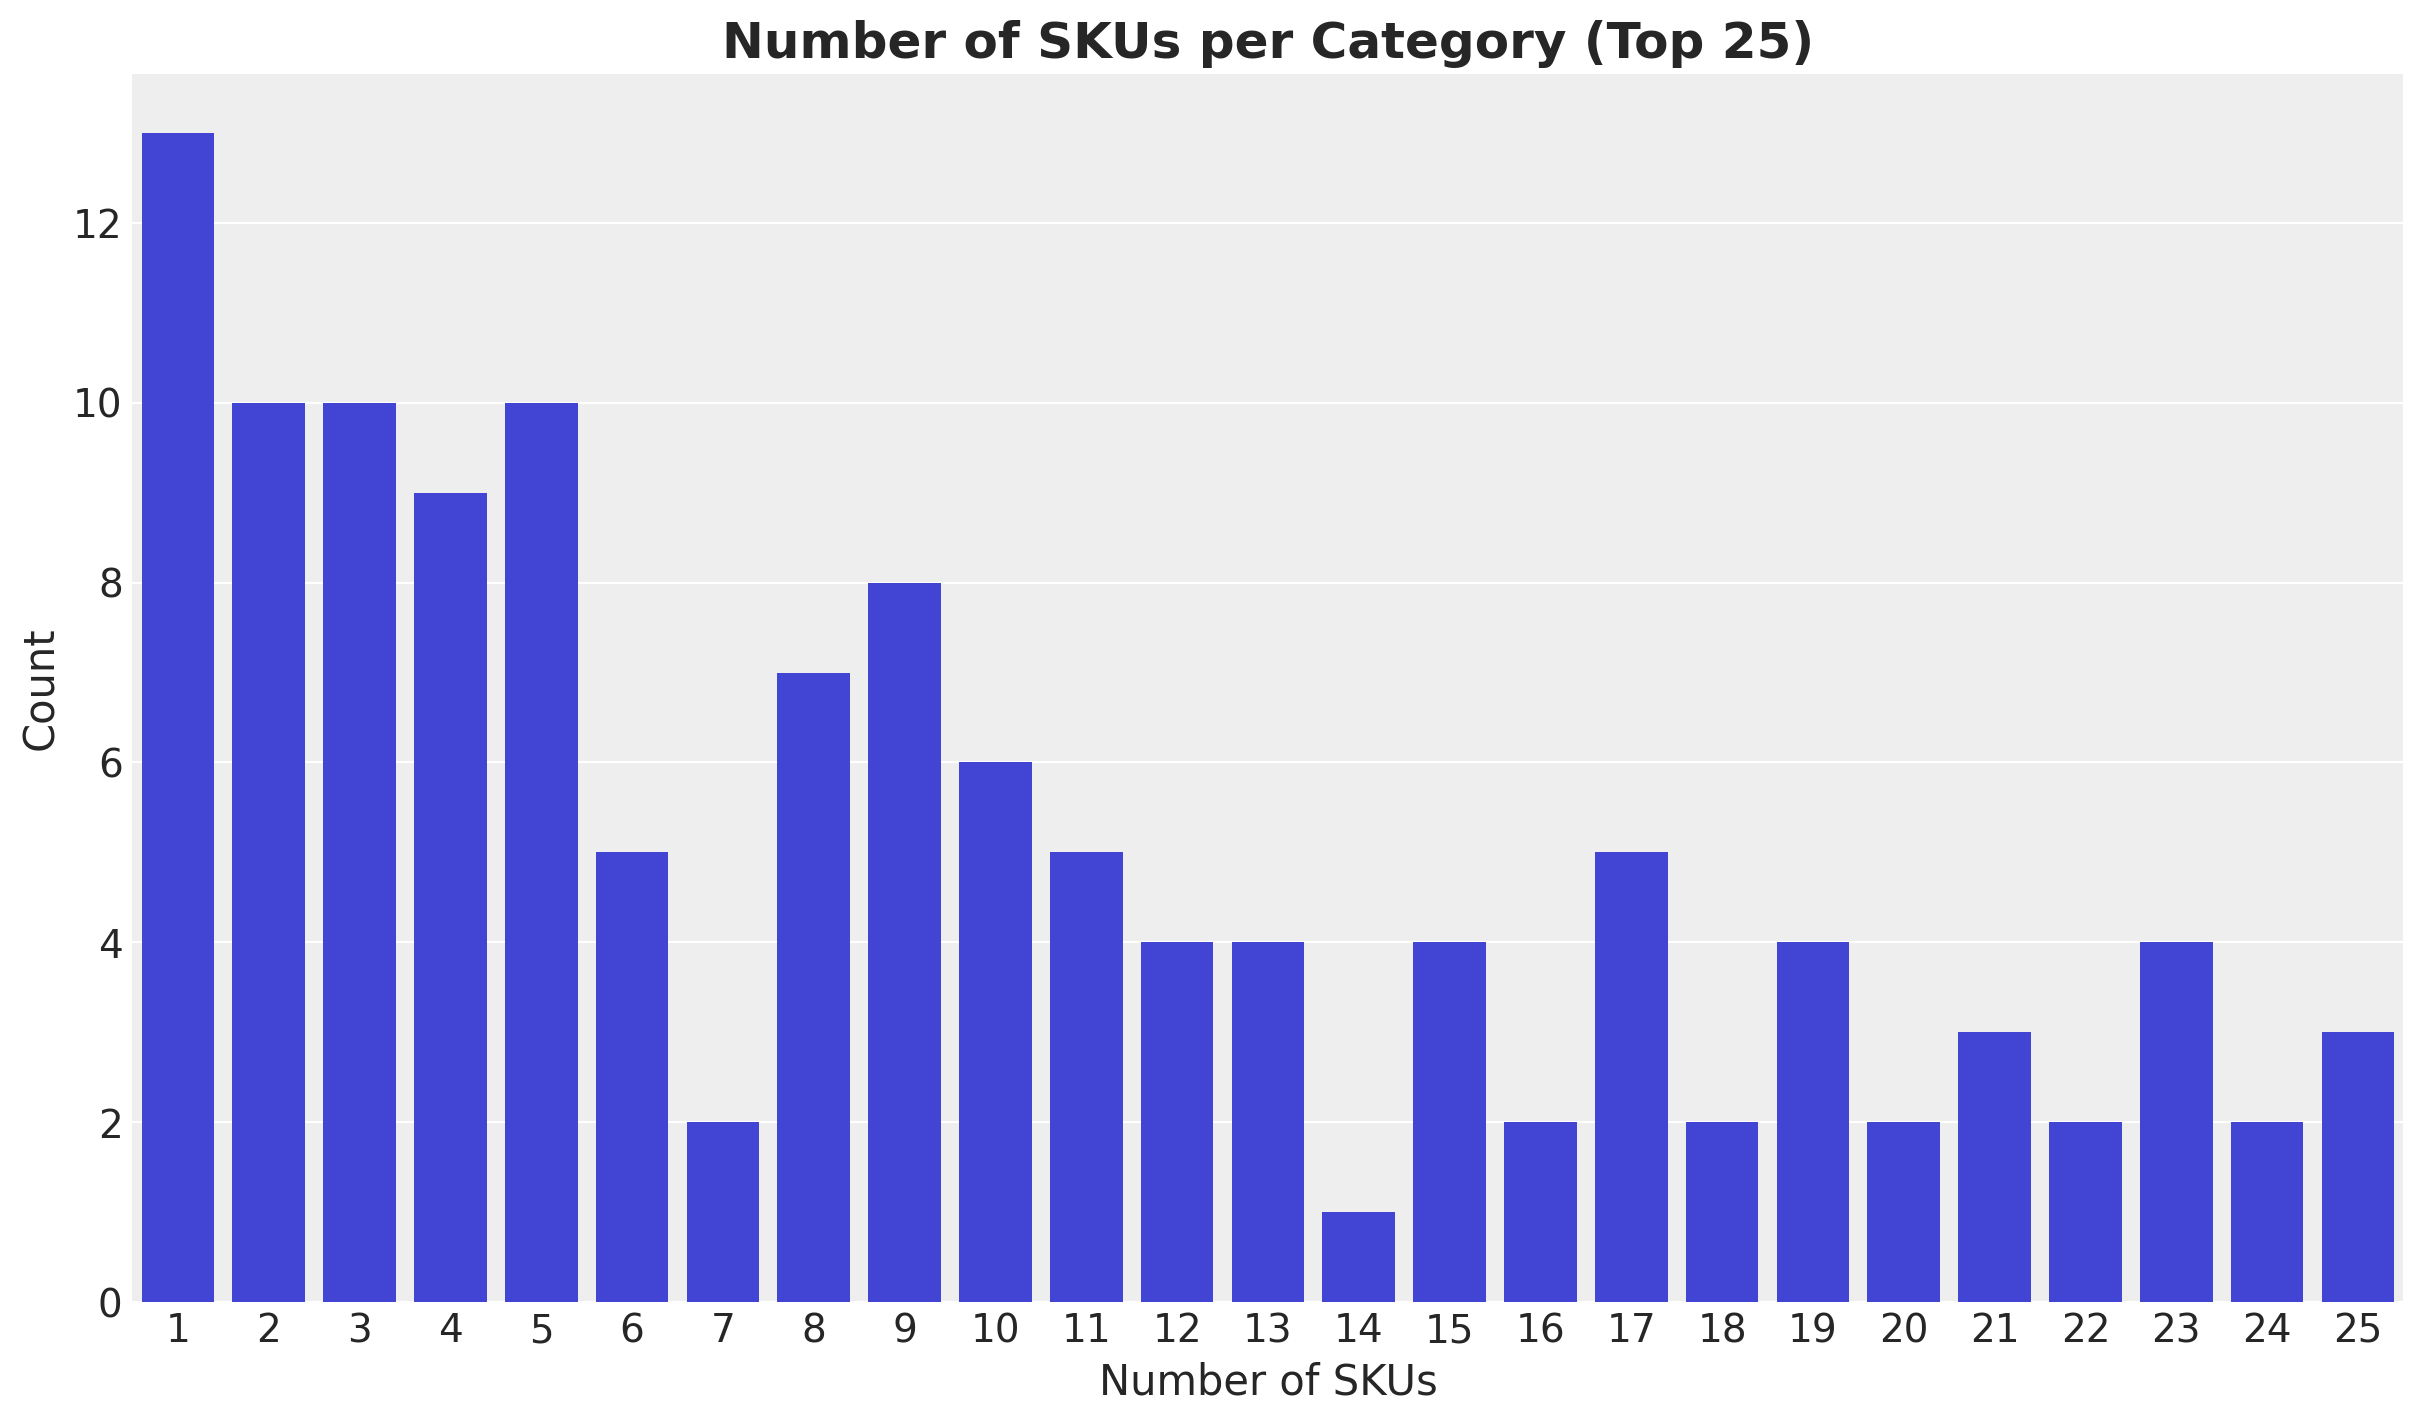

In [5]:
fig, ax = plt.subplots()
sns.barplot(
    data=data_df.group_by("sku_category")
    .agg(pl.col("sku").n_unique().alias("n_skus"))
    .group_by("n_skus")
    .len()
    .sort("n_skus")
    .head(25),
    x="n_skus",
    y="len",
    ax=ax,
)
ax.set(xlabel="Number of SKUs", ylabel="Count")
ax.set_title("Number of SKUs per Category (Top 25)", fontsize=18, fontweight="bold");

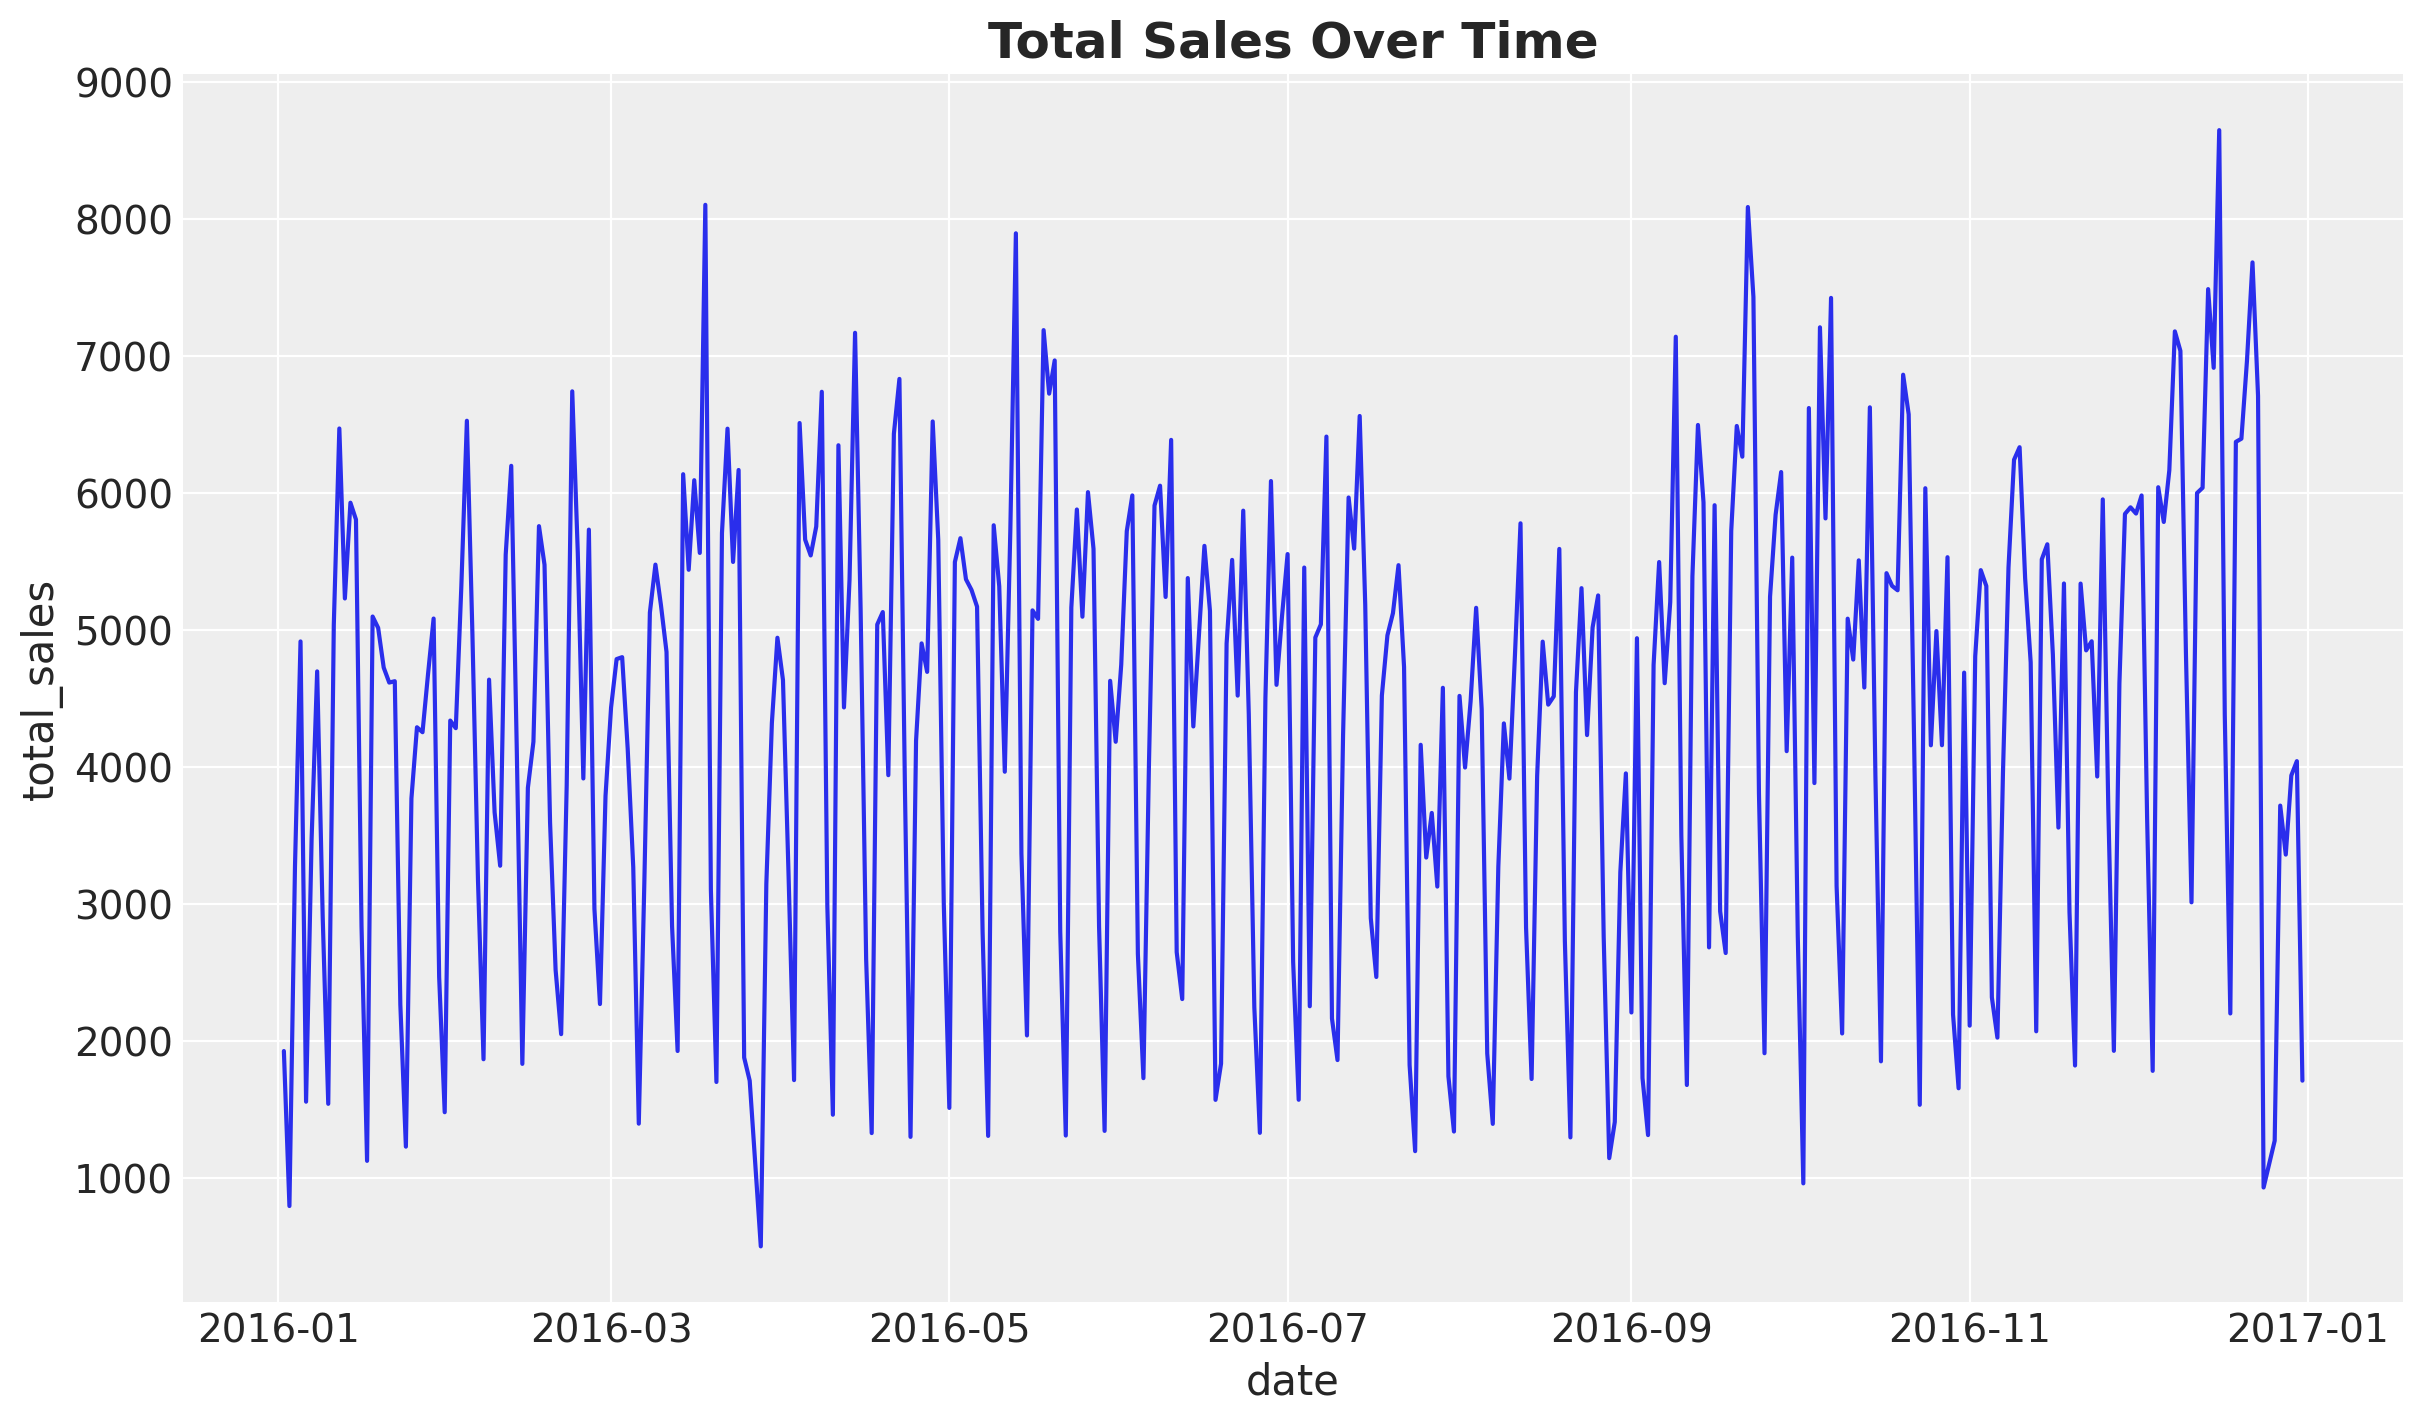

In [6]:
fig, ax = plt.subplots()
sns.lineplot(
    data=data_df.group_by("date").agg(
        pl.col("sales_amount").sum().alias("total_sales")
    ),
    x="date",
    y="total_sales",
    ax=ax,
)
ax.set_title("Total Sales Over Time", fontsize=18, fontweight="bold");

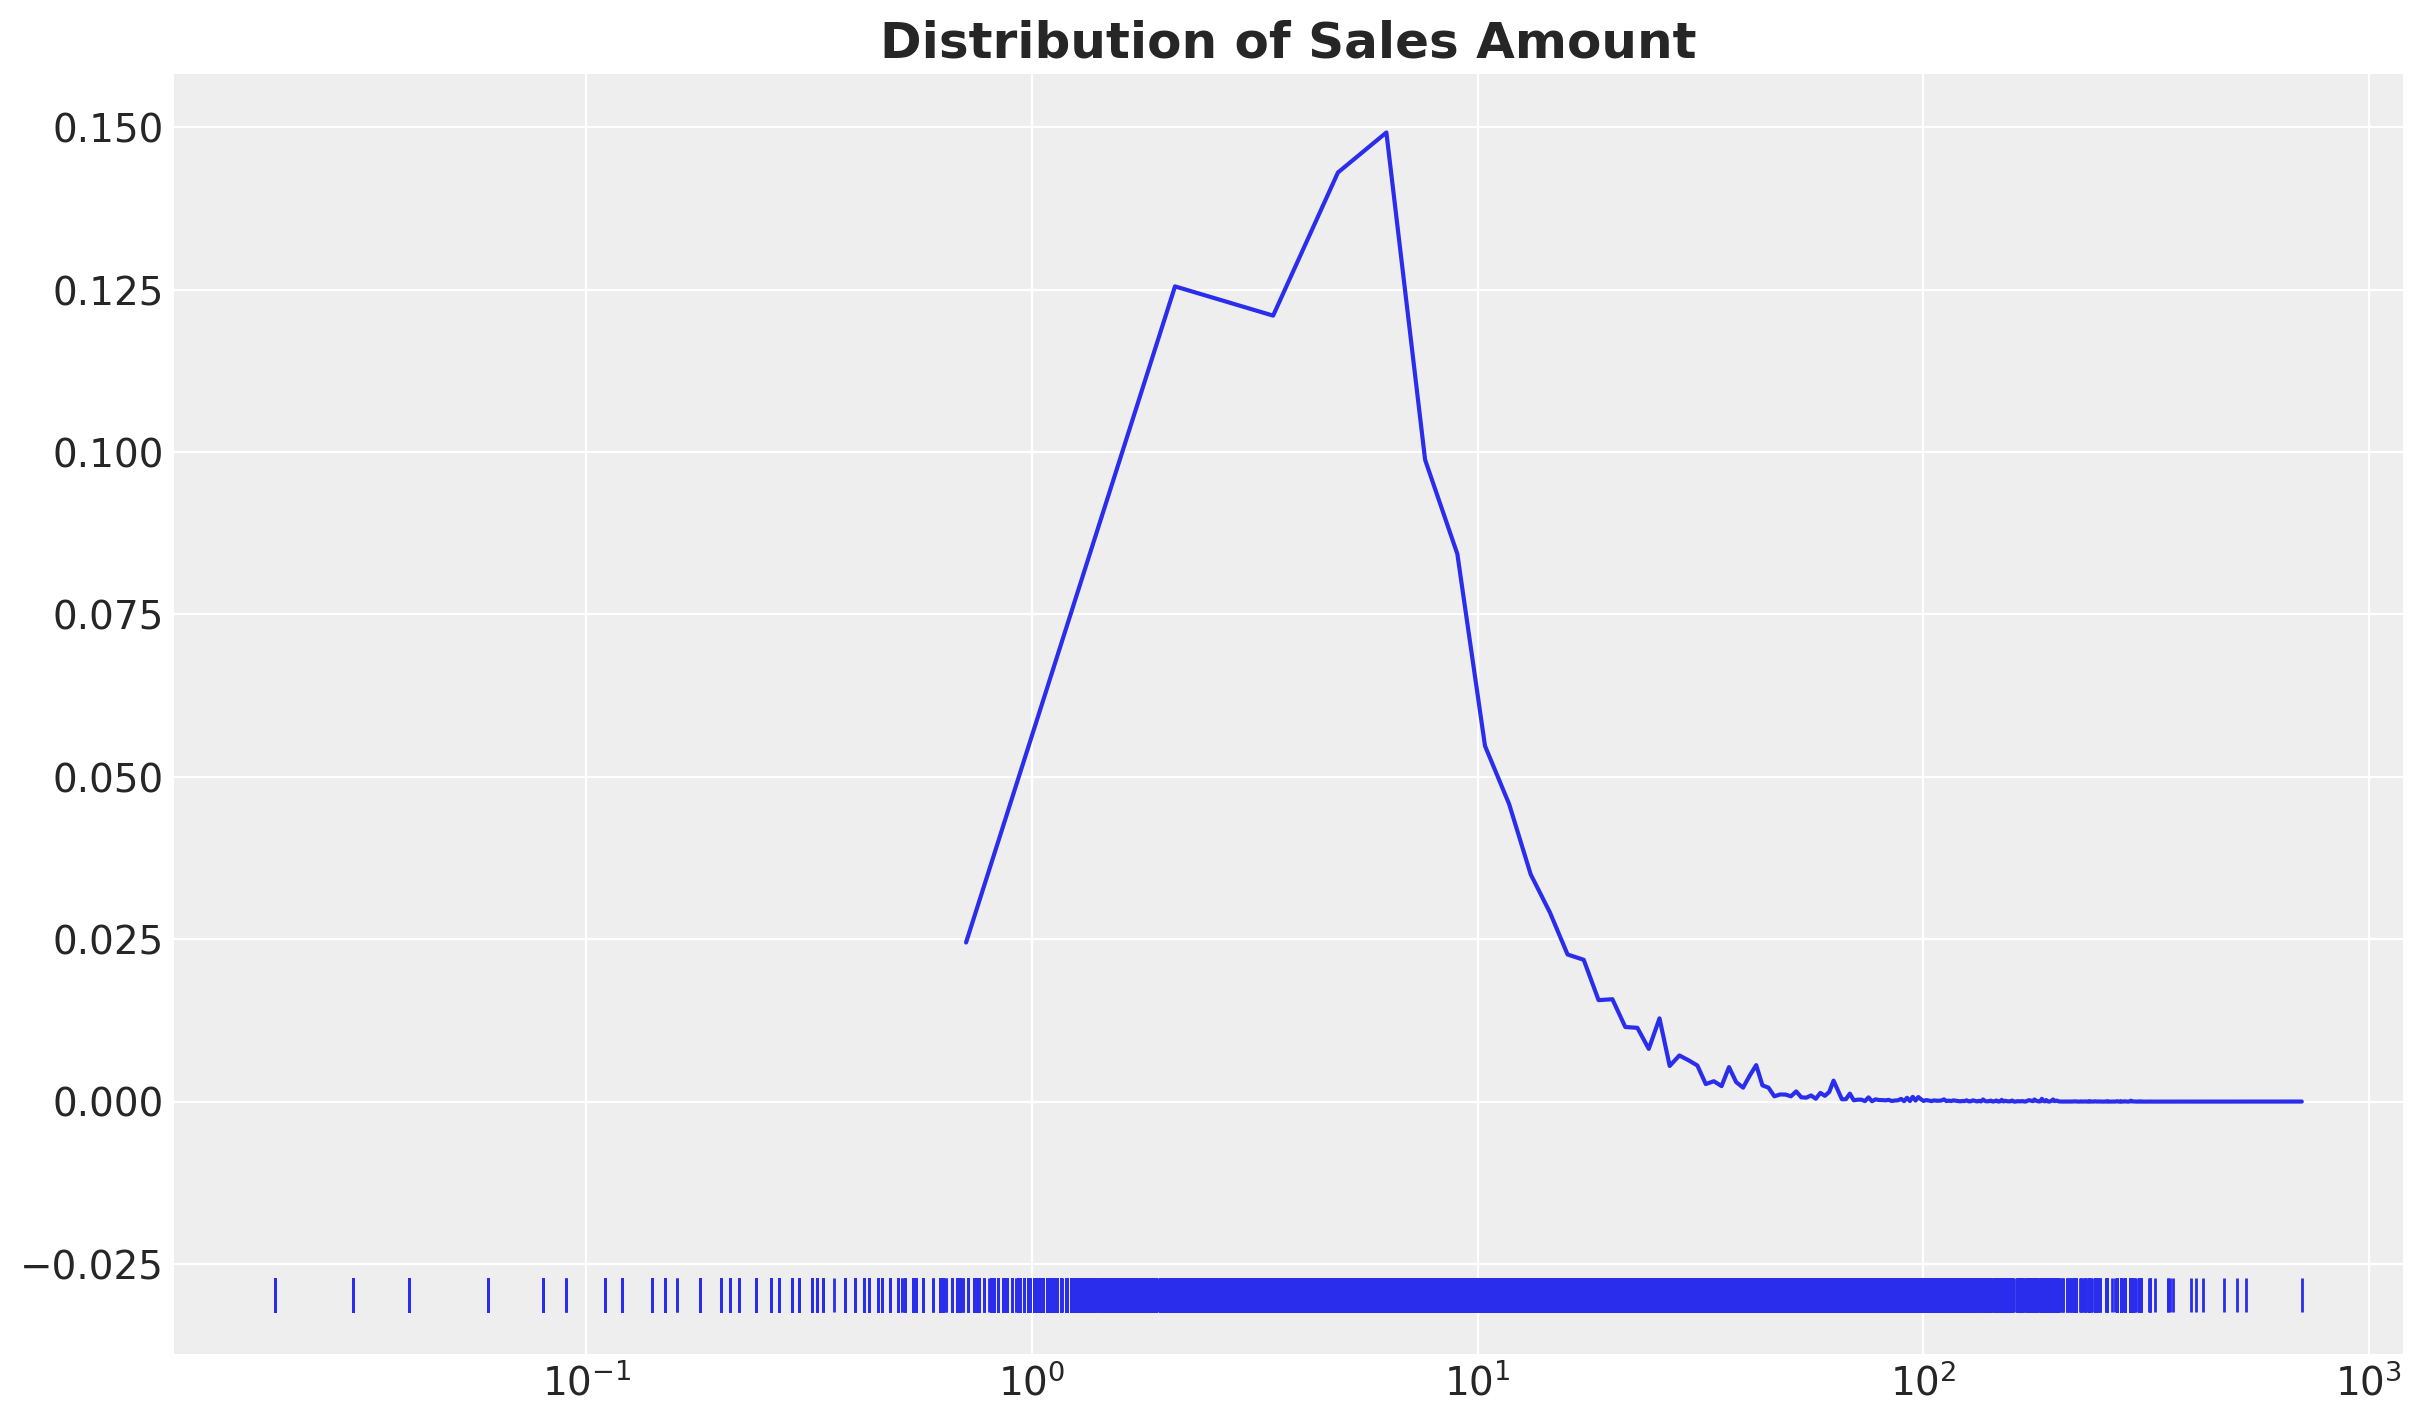

In [7]:
fig, ax = plt.subplots()
az.plot_dist(data_df["sales_amount"], rug=True, ax=ax)
ax.set(xscale="log")
ax.set_title("Distribution of Sales Amount", fontsize=18, fontweight="bold");

## Data Preparation 

In [8]:
n_dates_expr = pl.col("date").n_unique().over("sku").alias("n_dates")
n_prices_expr = pl.col("price").n_unique().over("sku").alias("n_prices")
log_price_expr = pl.col("price").log().alias("log_price")
log_quantity_expr = pl.col("quantity").log().alias("log_quantity")

n_dates_threshold = 10
n_prices_threshold = 10

n_dates_filter = pl.col("n_dates") > n_dates_threshold
n_prices_filter = pl.col("n_prices") > n_prices_threshold

model_df = (
    data_df.with_columns(n_dates_expr, n_prices_expr, log_price_expr, log_quantity_expr)
    .filter(n_dates_filter & n_prices_filter)
    .sort(by=["sku_category", "sku", "date"])
)

model_df.head()

date,sku_category,sku,quantity,sales_amount,price,n_dates,n_prices,log_price,log_quantity
date,str,str,f64,f64,f64,u32,u32,f64,f64
2016-01-02,"""0H2""","""ABFD7""",1.0,4.84,4.84,172,13,1.576915,0.0
2016-01-04,"""0H2""","""ABFD7""",1.0,4.84,4.84,172,13,1.576915,0.0
2016-01-04,"""0H2""","""ABFD7""",1.0,4.84,4.84,172,13,1.576915,0.0
2016-01-04,"""0H2""","""ABFD7""",1.0,4.84,4.84,172,13,1.576915,0.0
2016-01-05,"""0H2""","""ABFD7""",1.0,4.84,4.84,172,13,1.576915,0.0


In [9]:
print(f"Number of SKUs: {model_df['sku'].n_unique()}")
print(f"Number of SKUs Categories: {model_df['sku_category'].n_unique()}")

Number of SKUs: 87
Number of SKUs Categories: 33


In [10]:
obs_idx = np.arange(model_df.shape[0])

sku_encoder = LabelEncoder()
sku_idx = jnp.array(sku_encoder.fit_transform(model_df["sku"]))
sku = sku_encoder.classes_

sku_category_encoder = LabelEncoder()
sku_category_idx = jnp.array(
    sku_category_encoder.fit_transform(model_df["sku_category"])
)
sku_category = sku_category_encoder.classes_

date_encoder = LabelEncoder()
date_idx = jnp.array(
    date_encoder.fit_transform(
        model_df.select(pl.col("date").dt.strftime("%Y-%m-%d"))["date"]
    )
)
date = date_encoder.classes_

log_price = model_df["log_price"].to_jax()
log_quantity = model_df["log_quantity"].to_jax()

## Simple Elasticity Model

In [11]:
def simple_elasticity_model(log_price, sku_idx, log_quantity=None):
    n_obs = log_price.size
    n_sku = np.unique(sku_idx).size

    with numpyro.plate("sku", n_sku):
        sku_intercept = numpyro.sample("sku_intercept", dist.Normal(loc=0, scale=1))
        beta_log_price = numpyro.sample("beta_log_price", dist.Normal(loc=0, scale=1))
        sigma_sku = numpyro.sample("sigma", dist.HalfNormal(scale=1))

    mu = beta_log_price[sku_idx] * log_price + sku_intercept[sku_idx]

    sigma = sigma_sku[sku_idx]

    with numpyro.plate("data", n_obs):
        numpyro.sample("obs", dist.Normal(loc=mu, scale=sigma), obs=log_quantity)

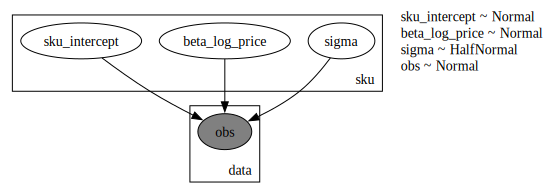

In [12]:
numpyro.render_model(
    model=simple_elasticity_model,
    model_kwargs={
        "log_price": log_price,
        "sku_idx": sku_idx,
        "log_quantity": log_quantity,
    },
    render_distributions=True,
    render_params=True,
)

100%|██████████| 25000/25000 [00:08<00:00, 2830.14it/s, init loss: 304577.6562, avg. loss [23751-25000]: -1819.7923]


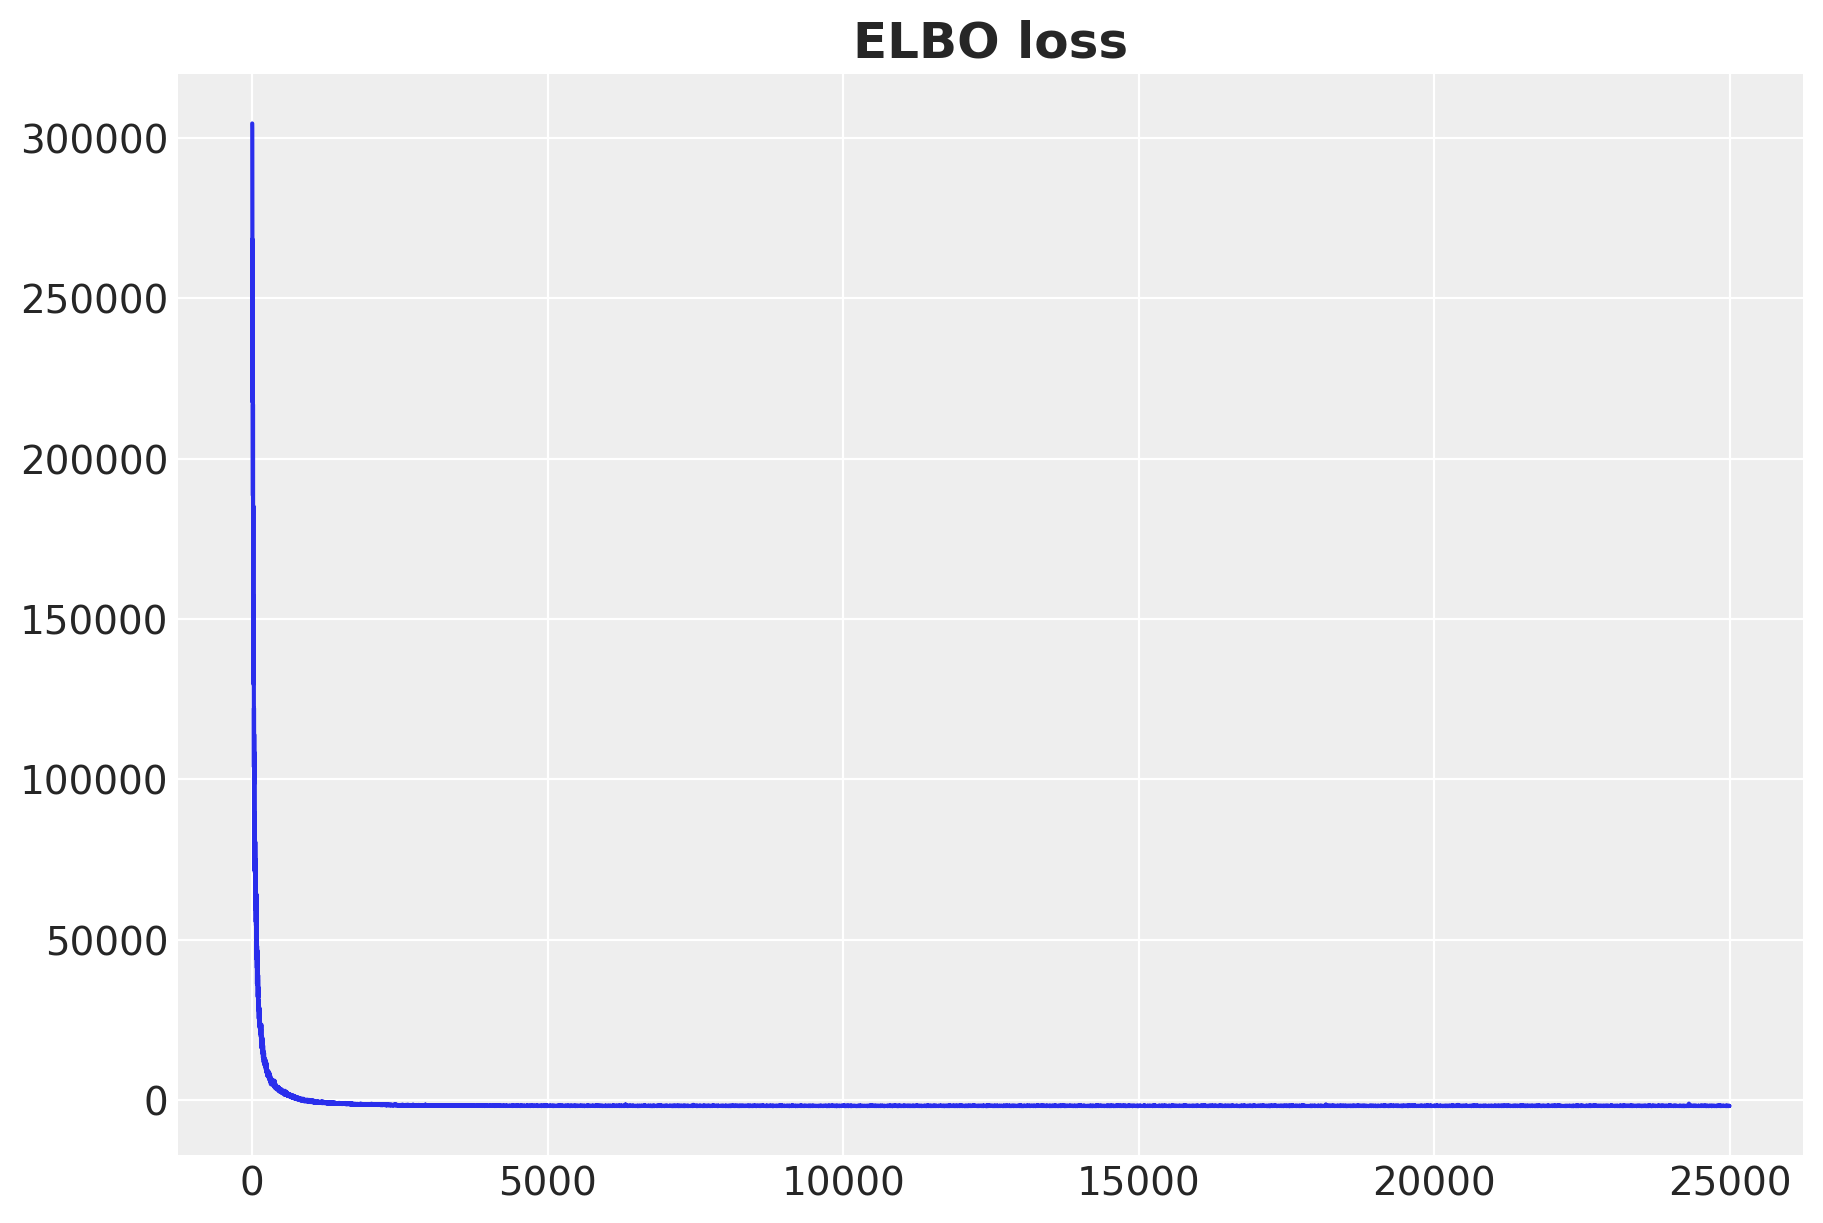

In [13]:
simple_guide = AutoNormal(simple_elasticity_model)
simple_optimizer = numpyro.optim.Adam(step_size=0.01)

simple_svi = SVI(
    simple_elasticity_model,
    simple_guide,
    simple_optimizer,
    loss=Trace_ELBO(),
)

num_steps = 25_000

rng_key, rng_subkey = random.split(key=rng_key)
simple_svi_result = simple_svi.run(
    rng_subkey,
    num_steps,
    log_price,
    sku_idx,
    log_quantity,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(simple_svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold");

In [14]:
rng_key, rng_subkey = random.split(rng_key)
simple_svi_posterior = Predictive(
    model=simple_elasticity_model,
    guide=simple_guide,
    params=simple_svi_result.params,
    num_samples=5_000,
    return_sites=[
        "beta_log_price",
        "sigma",
        "obs",
    ],
)(rng_subkey, log_price, sku_idx, log_quantity)

simple_svi_idata = az.from_dict(
    posterior={
        k: jnp.expand_dims(a=jnp.asarray(v), axis=0)
        for k, v in simple_svi_posterior.items()
    },
    coords={"sku": sku, "obs_idx": obs_idx},
    dims={
        "beta_log_price": ["sku"],
        "sigma": ["sku"],
        "obs": ["obs_idx"],
    },
)

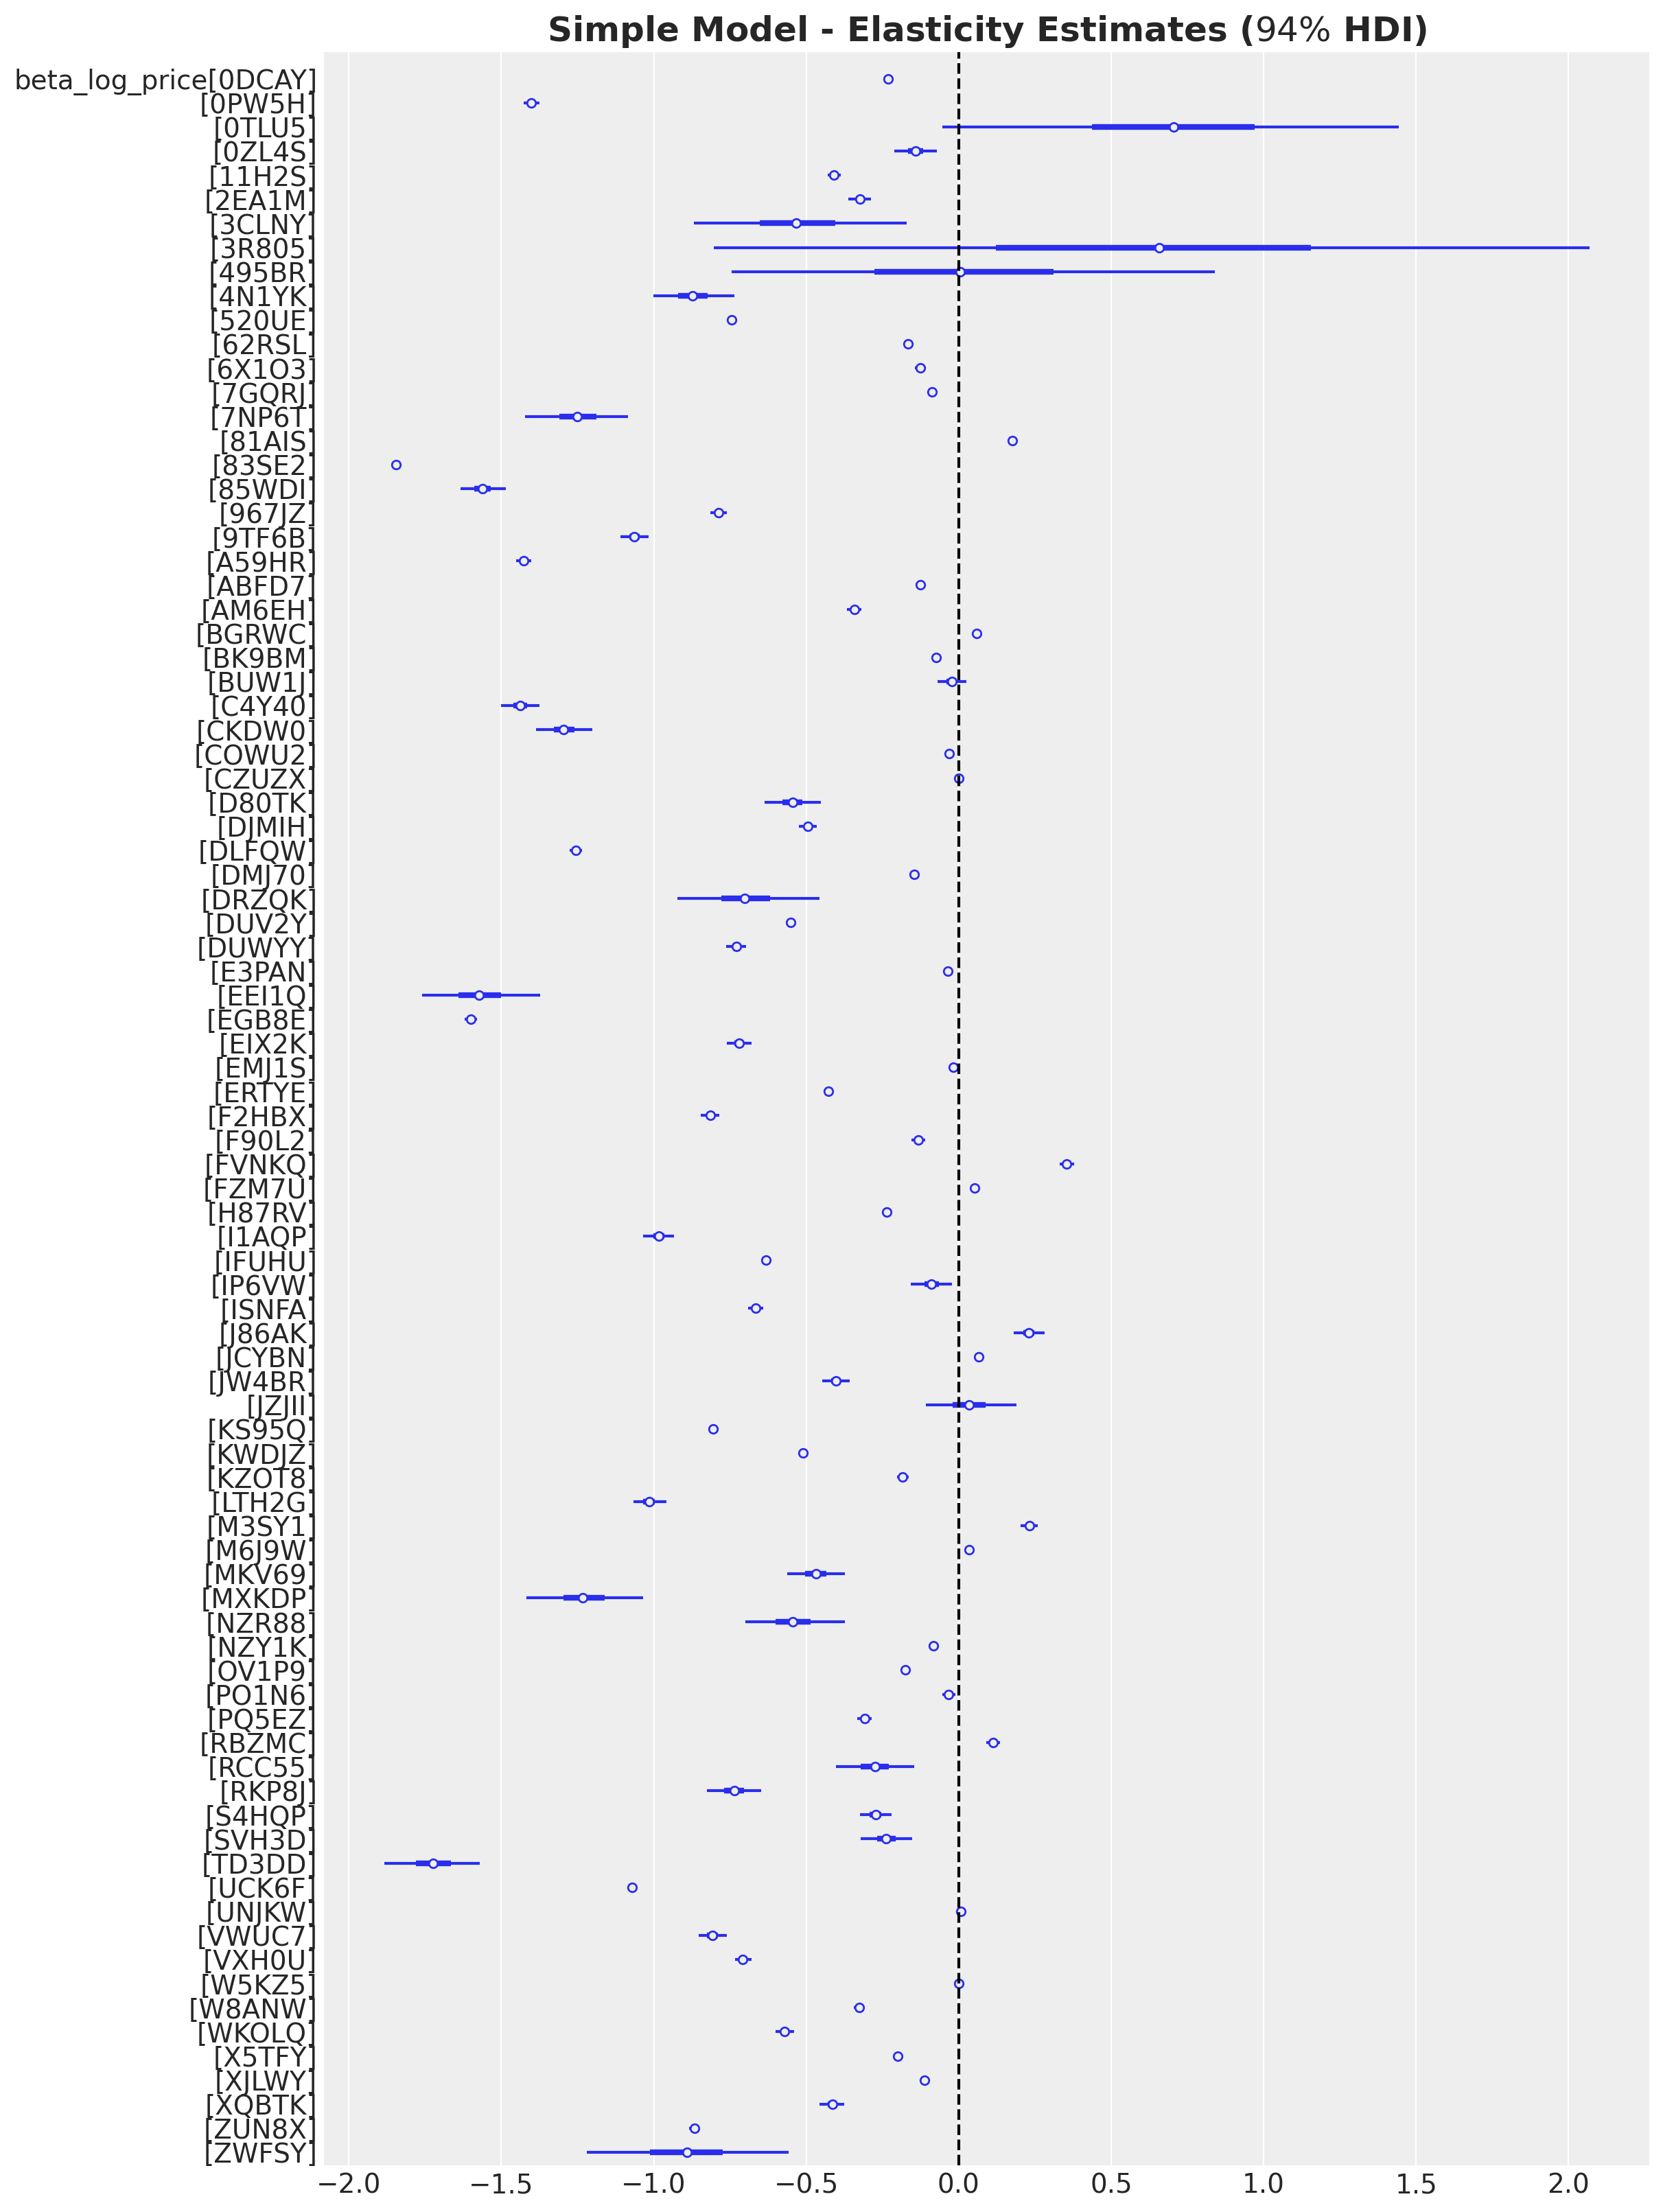

In [15]:
fig, ax = plt.subplots(figsize=(12, 16))
az.plot_forest(
    data=simple_svi_idata,
    var_names=["beta_log_price"],
    combined=True,
    ax=ax,
)
ax.axvline(x=0, color="black", linestyle="--")
ax.set_title(
    r"Simple Model - Elasticity Estimates ($94\%$ HDI)", fontsize=18, fontweight="bold"
);

## Fixed Effects Model

In [16]:
def fixed_effects_elasticity_model(log_price, sku_idx, date_idx, log_quantity=None):
    n_obs = log_price.size
    n_sku = np.unique(sku_idx).size
    n_date = np.unique(date_idx).size

    with numpyro.plate("sku", n_sku):
        sku_intercept = numpyro.sample("sku_intercept", dist.Normal(loc=0, scale=1))
        beta_log_price = numpyro.sample("beta_log_price", dist.Normal(loc=0, scale=1))
        sigma_sku = numpyro.sample("sigma", dist.HalfNormal(scale=5))

    with numpyro.plate("date", n_date):
        date_intercept = numpyro.sample("date_intercept", dist.Normal(loc=0, scale=1))

    mu = (
        beta_log_price[sku_idx] * log_price
        + sku_intercept[sku_idx]
        + date_intercept[date_idx]
    )

    sigma = sigma_sku[sku_idx]

    with numpyro.plate("data", n_obs):
        numpyro.sample("obs", dist.Normal(loc=mu, scale=sigma), obs=log_quantity)

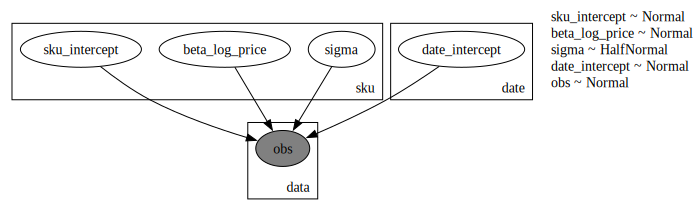

In [17]:
numpyro.render_model(
    model=fixed_effects_elasticity_model,
    model_kwargs={
        "log_price": log_price,
        "sku_idx": sku_idx,
        "date_idx": date_idx,
        "log_quantity": log_quantity,
    },
    render_distributions=True,
    render_params=True,
)

100%|██████████| 25000/25000 [00:11<00:00, 2270.18it/s, init loss: 356744.6562, avg. loss [23751-25000]: -506.9645]


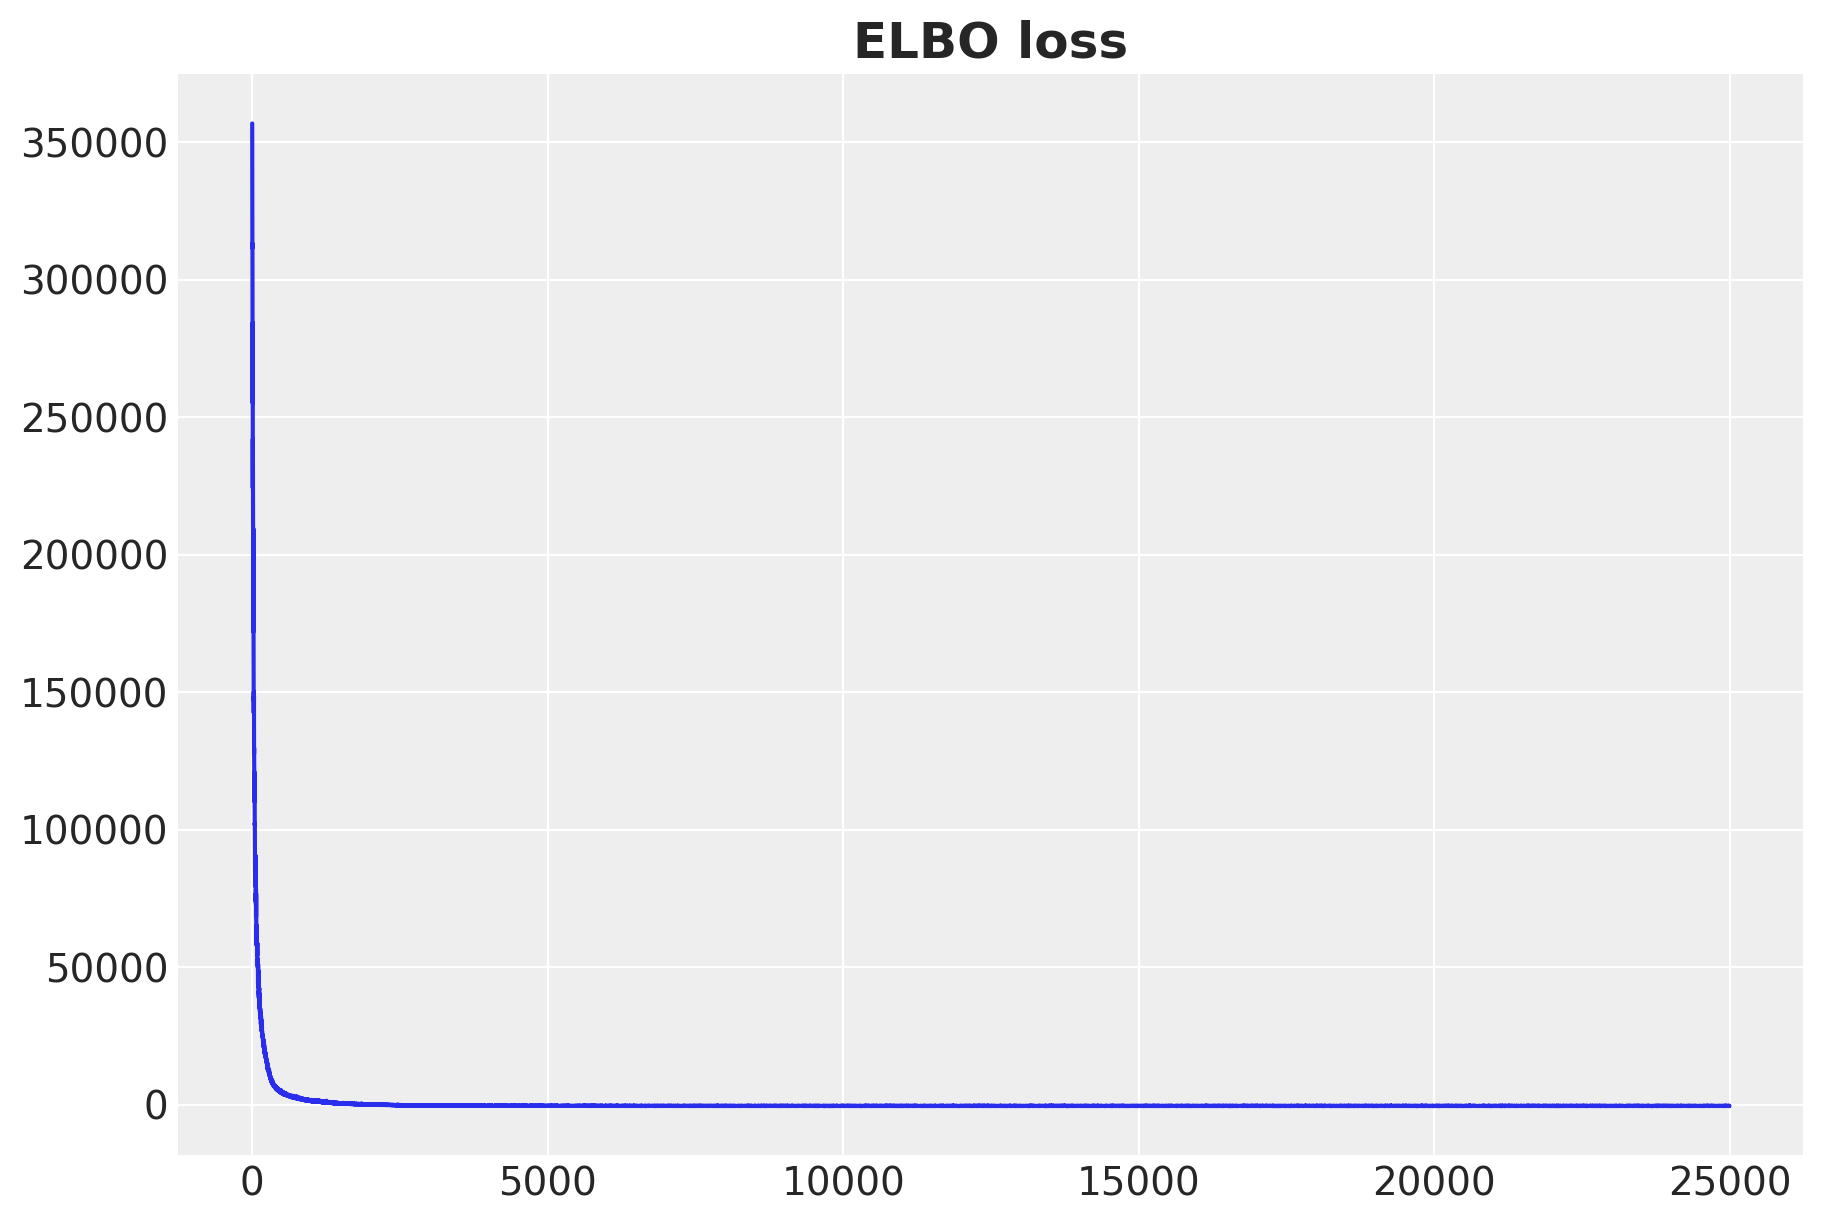

In [18]:
fixed_effects_guide = AutoNormal(fixed_effects_elasticity_model)
fixed_effects_optimizer = numpyro.optim.Adam(step_size=0.01)

fixed_effects_svi = SVI(
    fixed_effects_elasticity_model,
    fixed_effects_guide,
    fixed_effects_optimizer,
    loss=Trace_ELBO(),
)

num_steps = 25_000

rng_key, rng_subkey = random.split(key=rng_key)
fixed_effects_svi_result = fixed_effects_svi.run(
    rng_subkey,
    num_steps,
    log_price,
    sku_idx,
    date_idx,
    log_quantity,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(fixed_effects_svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold");

In [19]:
rng_key, rng_subkey = random.split(rng_key)
fixed_effects_svi_posterior = Predictive(
    model=fixed_effects_elasticity_model,
    guide=fixed_effects_guide,
    params=fixed_effects_svi_result.params,
    num_samples=5_000,
    return_sites=["beta_log_price"],
)(rng_subkey, log_price, sku_idx, date_idx, log_quantity)

fixed_effects_svi_idata = az.from_dict(
    posterior={
        k: jnp.expand_dims(a=jnp.asarray(v), axis=0)
        for k, v in fixed_effects_svi_posterior.items()
    },
    coords={"sku": sku, "obs_idx": obs_idx},
    dims={
        "beta_log_price": ["sku"],
        "sigma": ["sku"],
        "obs": ["obs_idx"],
    },
)

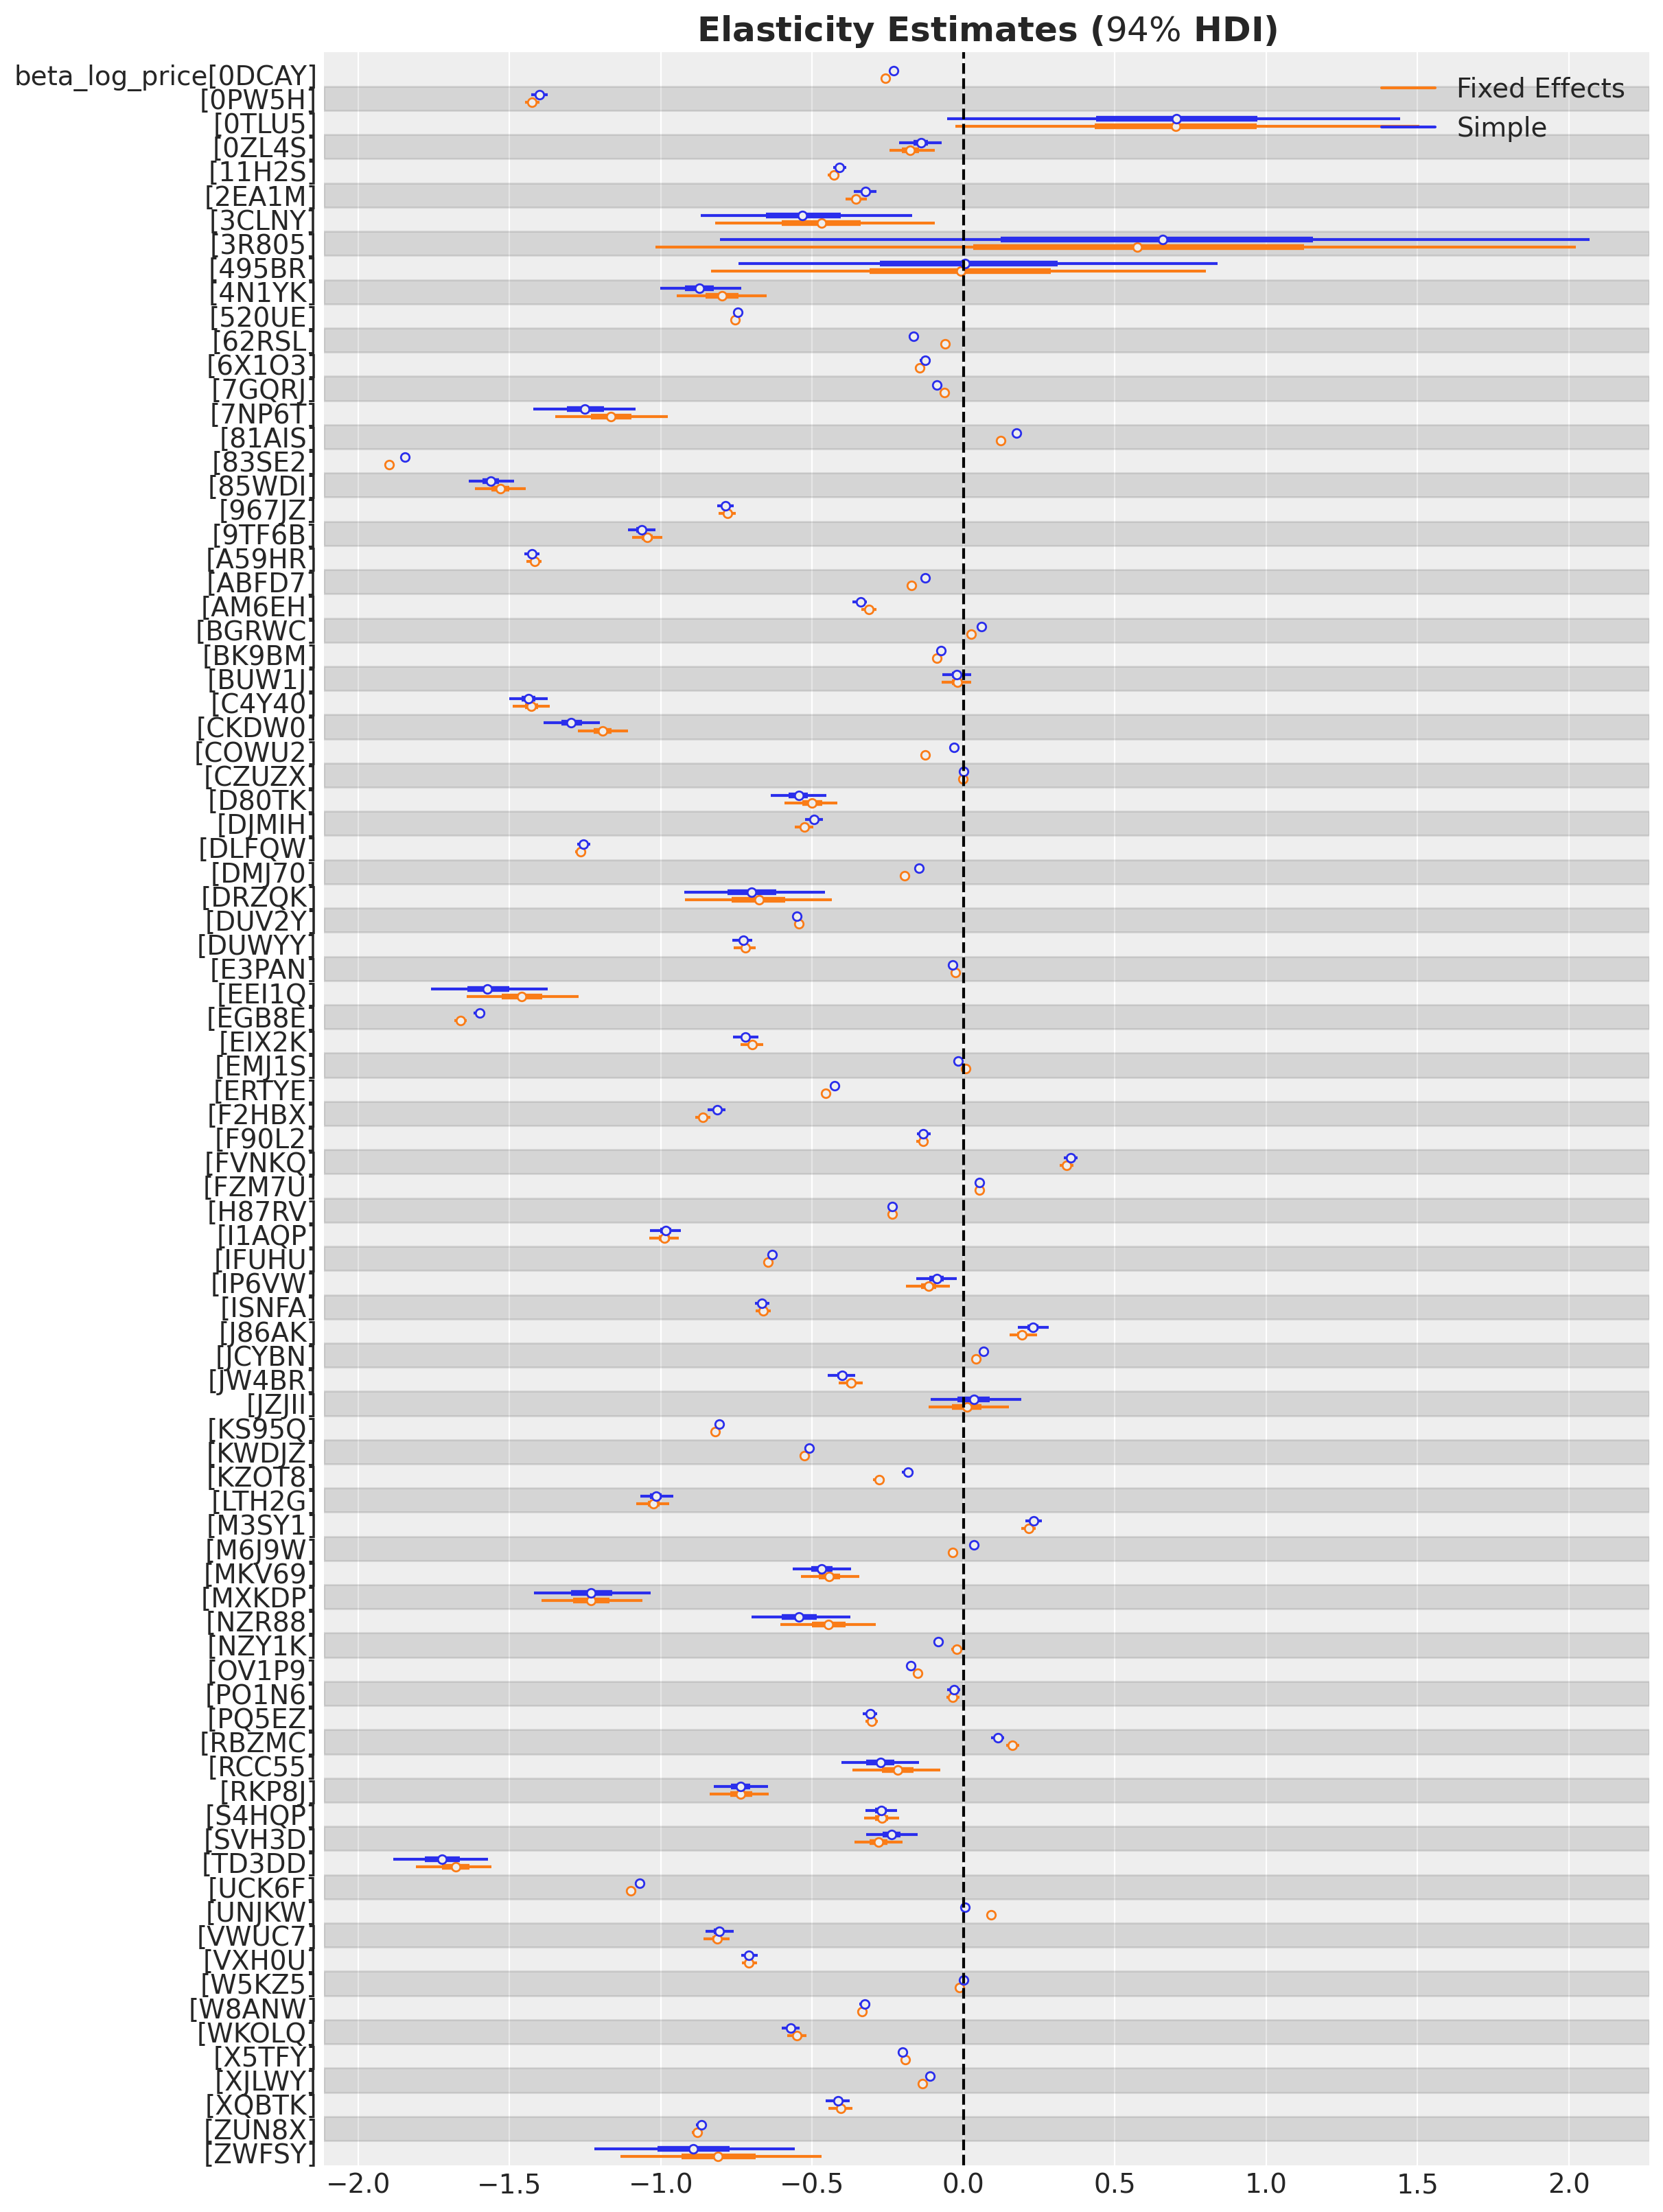

In [29]:
fig, ax = plt.subplots(figsize=(12, 16))
az.plot_forest(
    data=[simple_svi_idata, fixed_effects_svi_idata],
    model_names=["Simple", "Fixed Effects"],
    var_names=["beta_log_price"],
    combined=True,
    ax=ax,
)
ax.axvline(x=0, color="black", linestyle="--")
ax.set_title(
    r"Elasticity Estimates ($94\%$ HDI)",
    fontsize=18,
    fontweight="bold",
);

## Hierarchical Model

In [21]:
sku_category_mapping_df = (
    model_df.select(["sku", "sku_category"]).unique().sort(["sku", "sku_category"])
)

sku_category_mapping_df = sku_category_mapping_df.with_columns(
    sku_idx=sku_encoder.transform(sku_category_mapping_df["sku"]),
    sku_category_idx=sku_category_encoder.transform(
        sku_category_mapping_df["sku_category"]
    ),
).sort("sku_idx")

sku_category_mapping = sku_category_mapping_df["sku_category_idx"].to_jax()

In [22]:
def hierarchical_elasticity_model(
    log_price,
    sku_idx,
    date_idx,
    sku_category_idx,
    sku_category_mapping,
    log_quantity=None,
    subsample_size=None,
):
    n_obs = log_price.size
    n_sku = np.unique(sku_idx).size
    n_sku_category = np.unique(sku_category_idx).size
    n_date = np.unique(date_idx).size

    beta_log_price_loc_loc = numpyro.sample(
        "beta_log_price_loc_loc", dist.Normal(loc=0, scale=1)
    )
    beta_log_price_loc_scale = numpyro.sample(
        "beta_log_price_loc_scale", dist.HalfNormal(scale=1)
    )

    beta_log_price_scale_scale = numpyro.sample(
        "beta_log_price_scale_scale", dist.HalfNormal(scale=1)
    )

    sigma_global = numpyro.sample("sigma_global", dist.HalfNormal(scale=1))

    with numpyro.plate("sku_category", n_sku_category):
        beta_log_price_loc = numpyro.sample(
            "beta_log_price_loc",
            dist.Normal(loc=beta_log_price_loc_loc, scale=beta_log_price_loc_scale),
        )
        beta_log_price_scale = numpyro.sample(
            "beta_log_price_scale", dist.HalfNormal(scale=beta_log_price_scale_scale)
        )

        sigma_sku_category = numpyro.sample(
            "sigma_sku_category", dist.HalfNormal(scale=sigma_global)
        )

    with numpyro.plate("sku", n_sku):
        sku_intercept = numpyro.sample("sku_intercept", dist.Normal(loc=0, scale=1))
        beta_log_price = numpyro.sample(
            "beta_log_price",
            dist.Normal(
                loc=beta_log_price_loc[sku_category_mapping],
                scale=beta_log_price_scale[sku_category_mapping],
            ),
        )

    with numpyro.plate("date", n_date):
        date_intercept = numpyro.sample("date_intercept", dist.Normal(loc=0, scale=1))

    mu = (
        beta_log_price[sku_idx] * log_price
        + sku_intercept[sku_idx]
        + date_intercept[date_idx]
    )

    sigma = sigma_sku_category[sku_category_idx]

    with numpyro.plate("data", n_obs, subsample_size=subsample_size):
        numpyro.sample("obs", dist.Normal(loc=mu, scale=sigma), obs=log_quantity)

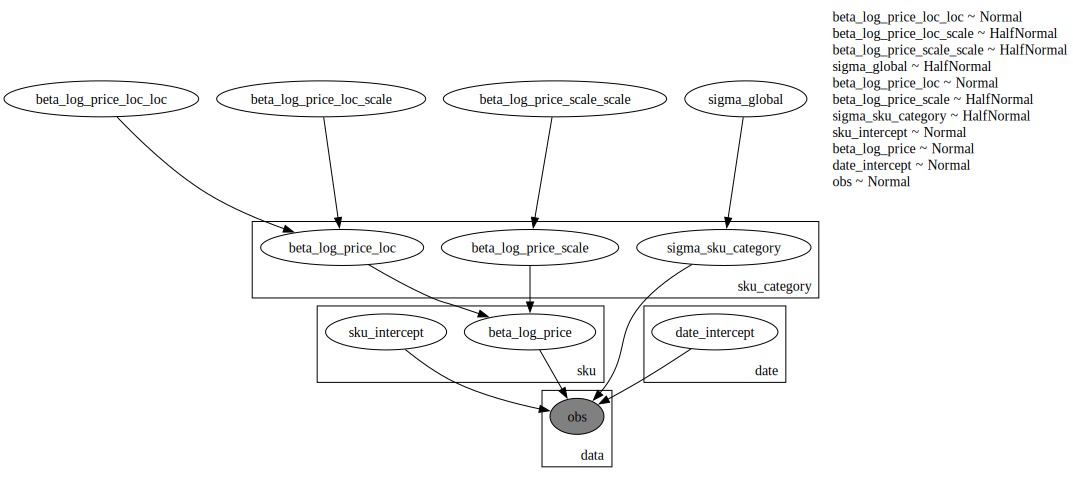

In [23]:
numpyro.render_model(
    model=hierarchical_elasticity_model,
    model_kwargs={
        "log_price": log_price,
        "sku_idx": sku_idx,
        "date_idx": date_idx,
        "sku_category_idx": sku_category_idx,
        "sku_category_mapping": sku_category_mapping,
        "log_quantity": log_quantity,
    },
    render_distributions=True,
    render_params=True,
)

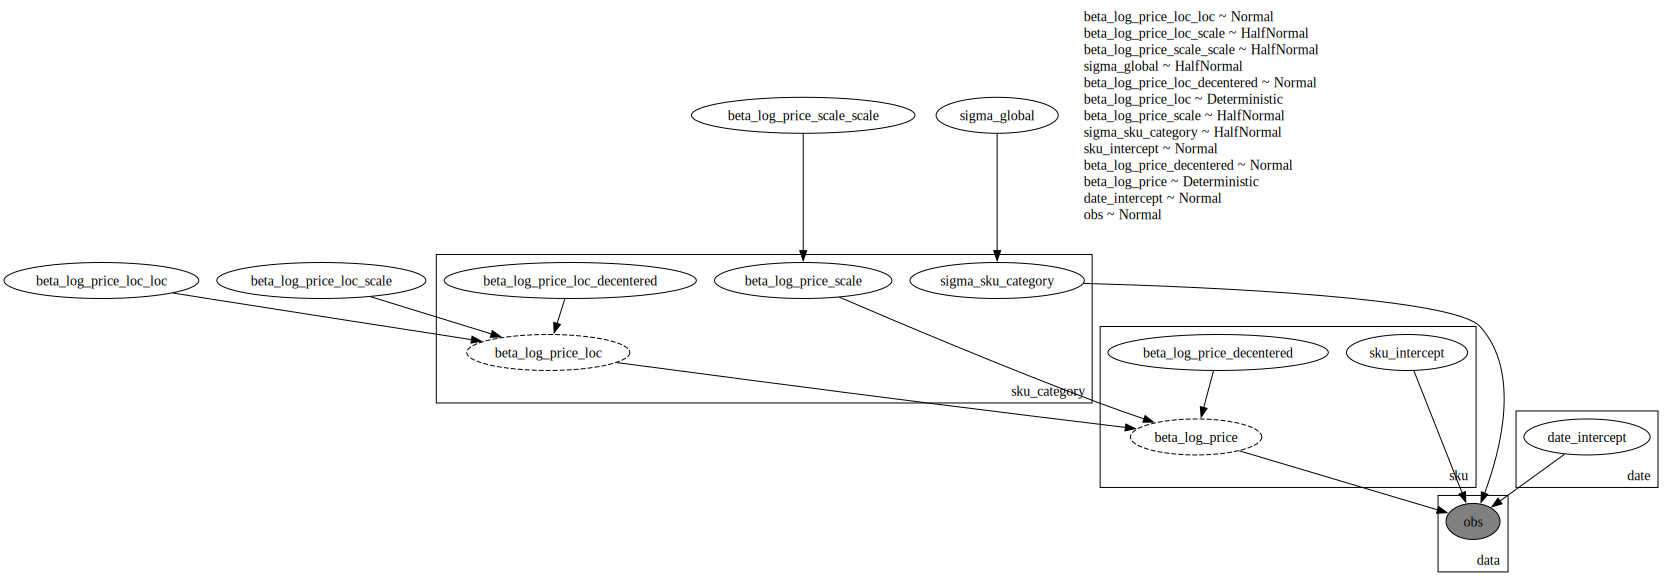

In [24]:
reparam_config = {
    "beta_log_price_loc": LocScaleReparam(0),
    "beta_log_price": LocScaleReparam(0),
}

reparam_hierarchical_elasticity_model = reparam(
    fn=hierarchical_elasticity_model, config=reparam_config
)

numpyro.render_model(
    model=reparam_hierarchical_elasticity_model,
    model_kwargs={
        "log_price": log_price,
        "sku_idx": sku_idx,
        "date_idx": date_idx,
        "sku_category_idx": sku_category_idx,
        "sku_category_mapping": sku_category_mapping,
        "log_quantity": log_quantity,
    },
    render_distributions=True,
    render_params=True,
)

100%|██████████| 25000/25000 [00:18<00:00, 1386.86it/s, init loss: 2120123.0000, avg. loss [23751-25000]: 531.0656]


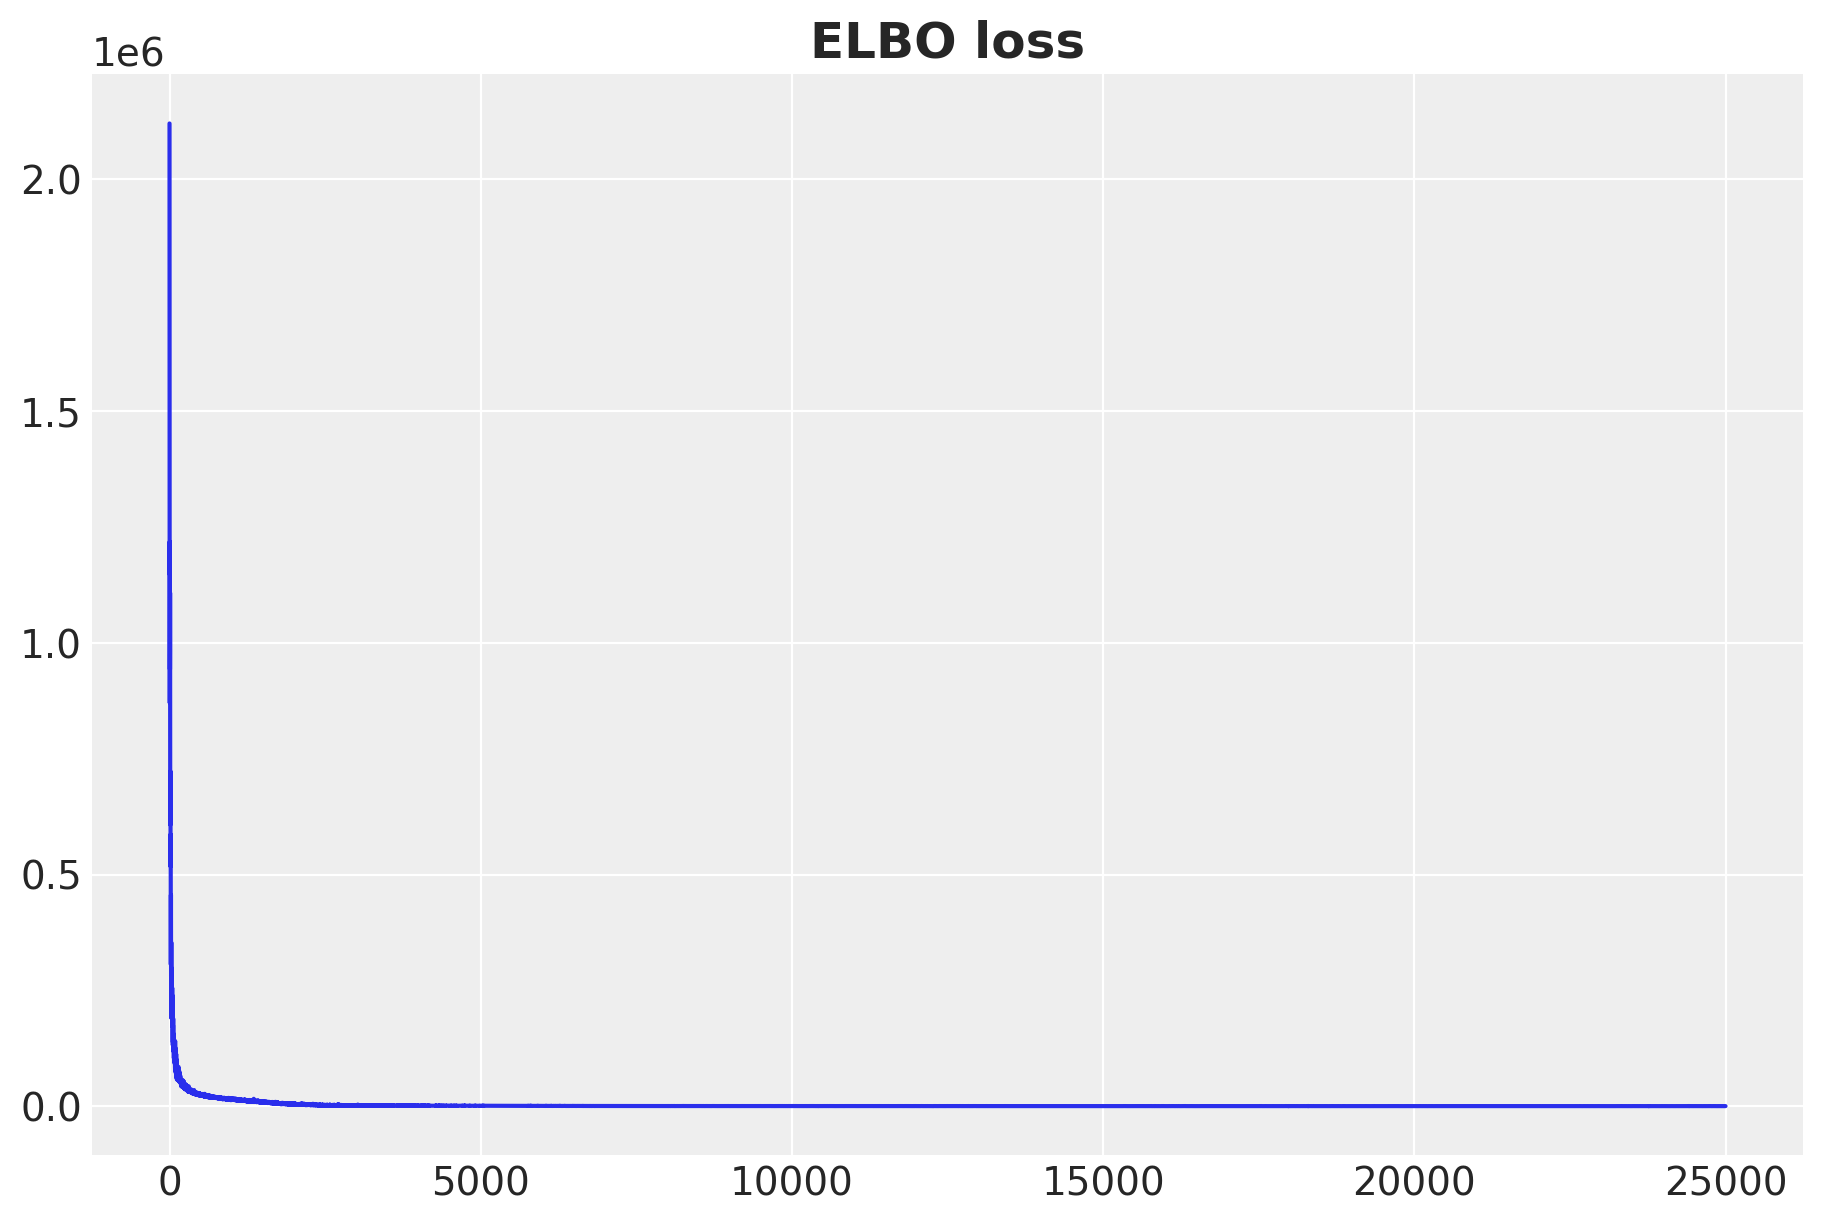

In [25]:
guide = AutoGuideList(reparam_hierarchical_elasticity_model)

rng_key, rng_subkey = random.split(key=rng_key)

guide.append(
    AutoNormal(
        block(
            seed(reparam_hierarchical_elasticity_model, rng_subkey),
            hide=[
                "beta_log_price_loc_decentered",
                "beta_log_price_loc",  # deterministic
                "beta_log_price_scale",
                "beta_log_price",  # deterministic
                "sigma_sku_category",
                "sku_category",
            ],
        )
    )
)

rng_key, rng_subkey = random.split(key=rng_key)

guide.append(
    AutoMultivariateNormal(
        block(
            seed(reparam_hierarchical_elasticity_model, rng_subkey),
            expose=[
                "beta_log_price_loc_decentered",
                "beta_log_price_scale",
                "sigma_sku_category",
                "sku_category",
            ],
        )
    )
)

optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(
    reparam_hierarchical_elasticity_model,
    guide,
    optimizer,
    loss=Trace_ELBO(),
)

num_steps = 25_000

rng_key, rng_subkey = random.split(key=rng_key)
svi_result = svi.run(
    rng_subkey,
    num_steps,
    log_price,
    sku_idx,
    date_idx,
    sku_category_idx,
    sku_category_mapping,
    log_quantity,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold");

In [26]:
rng_key, rng_subkey = random.split(rng_key)
svi_posterior = Predictive(
    model=reparam_hierarchical_elasticity_model,
    guide=guide,
    params=svi_result.params,
    num_samples=5_000,
    return_sites=[
        "beta_log_price_loc",
        "beta_log_price_scale",
        "beta_log_price",
        "sigma",
        "sku_intercept",
        "date_intercept",
        "sigma_sku_category",
    ],
)(
    rng_subkey,
    log_price,
    sku_idx,
    date_idx,
    sku_category_idx,
    sku_category_mapping,
    log_quantity,
)

svi_idata = az.from_dict(
    posterior={
        k: np.expand_dims(a=np.asarray(v), axis=0) for k, v in svi_posterior.items()
    },
    coords={"sku": sku, "sku_category": sku_category, "date": date},
    dims={
        "beta_log_price_loc": ["sku_category"],
        "beta_log_price_scale": ["sku_category"],
        "beta_log_price": ["sku"],
        "sku_intercept": ["sku"],
        "date_intercept": ["date"],
        "sigma_sku_category": ["sku_category"],
    },
)

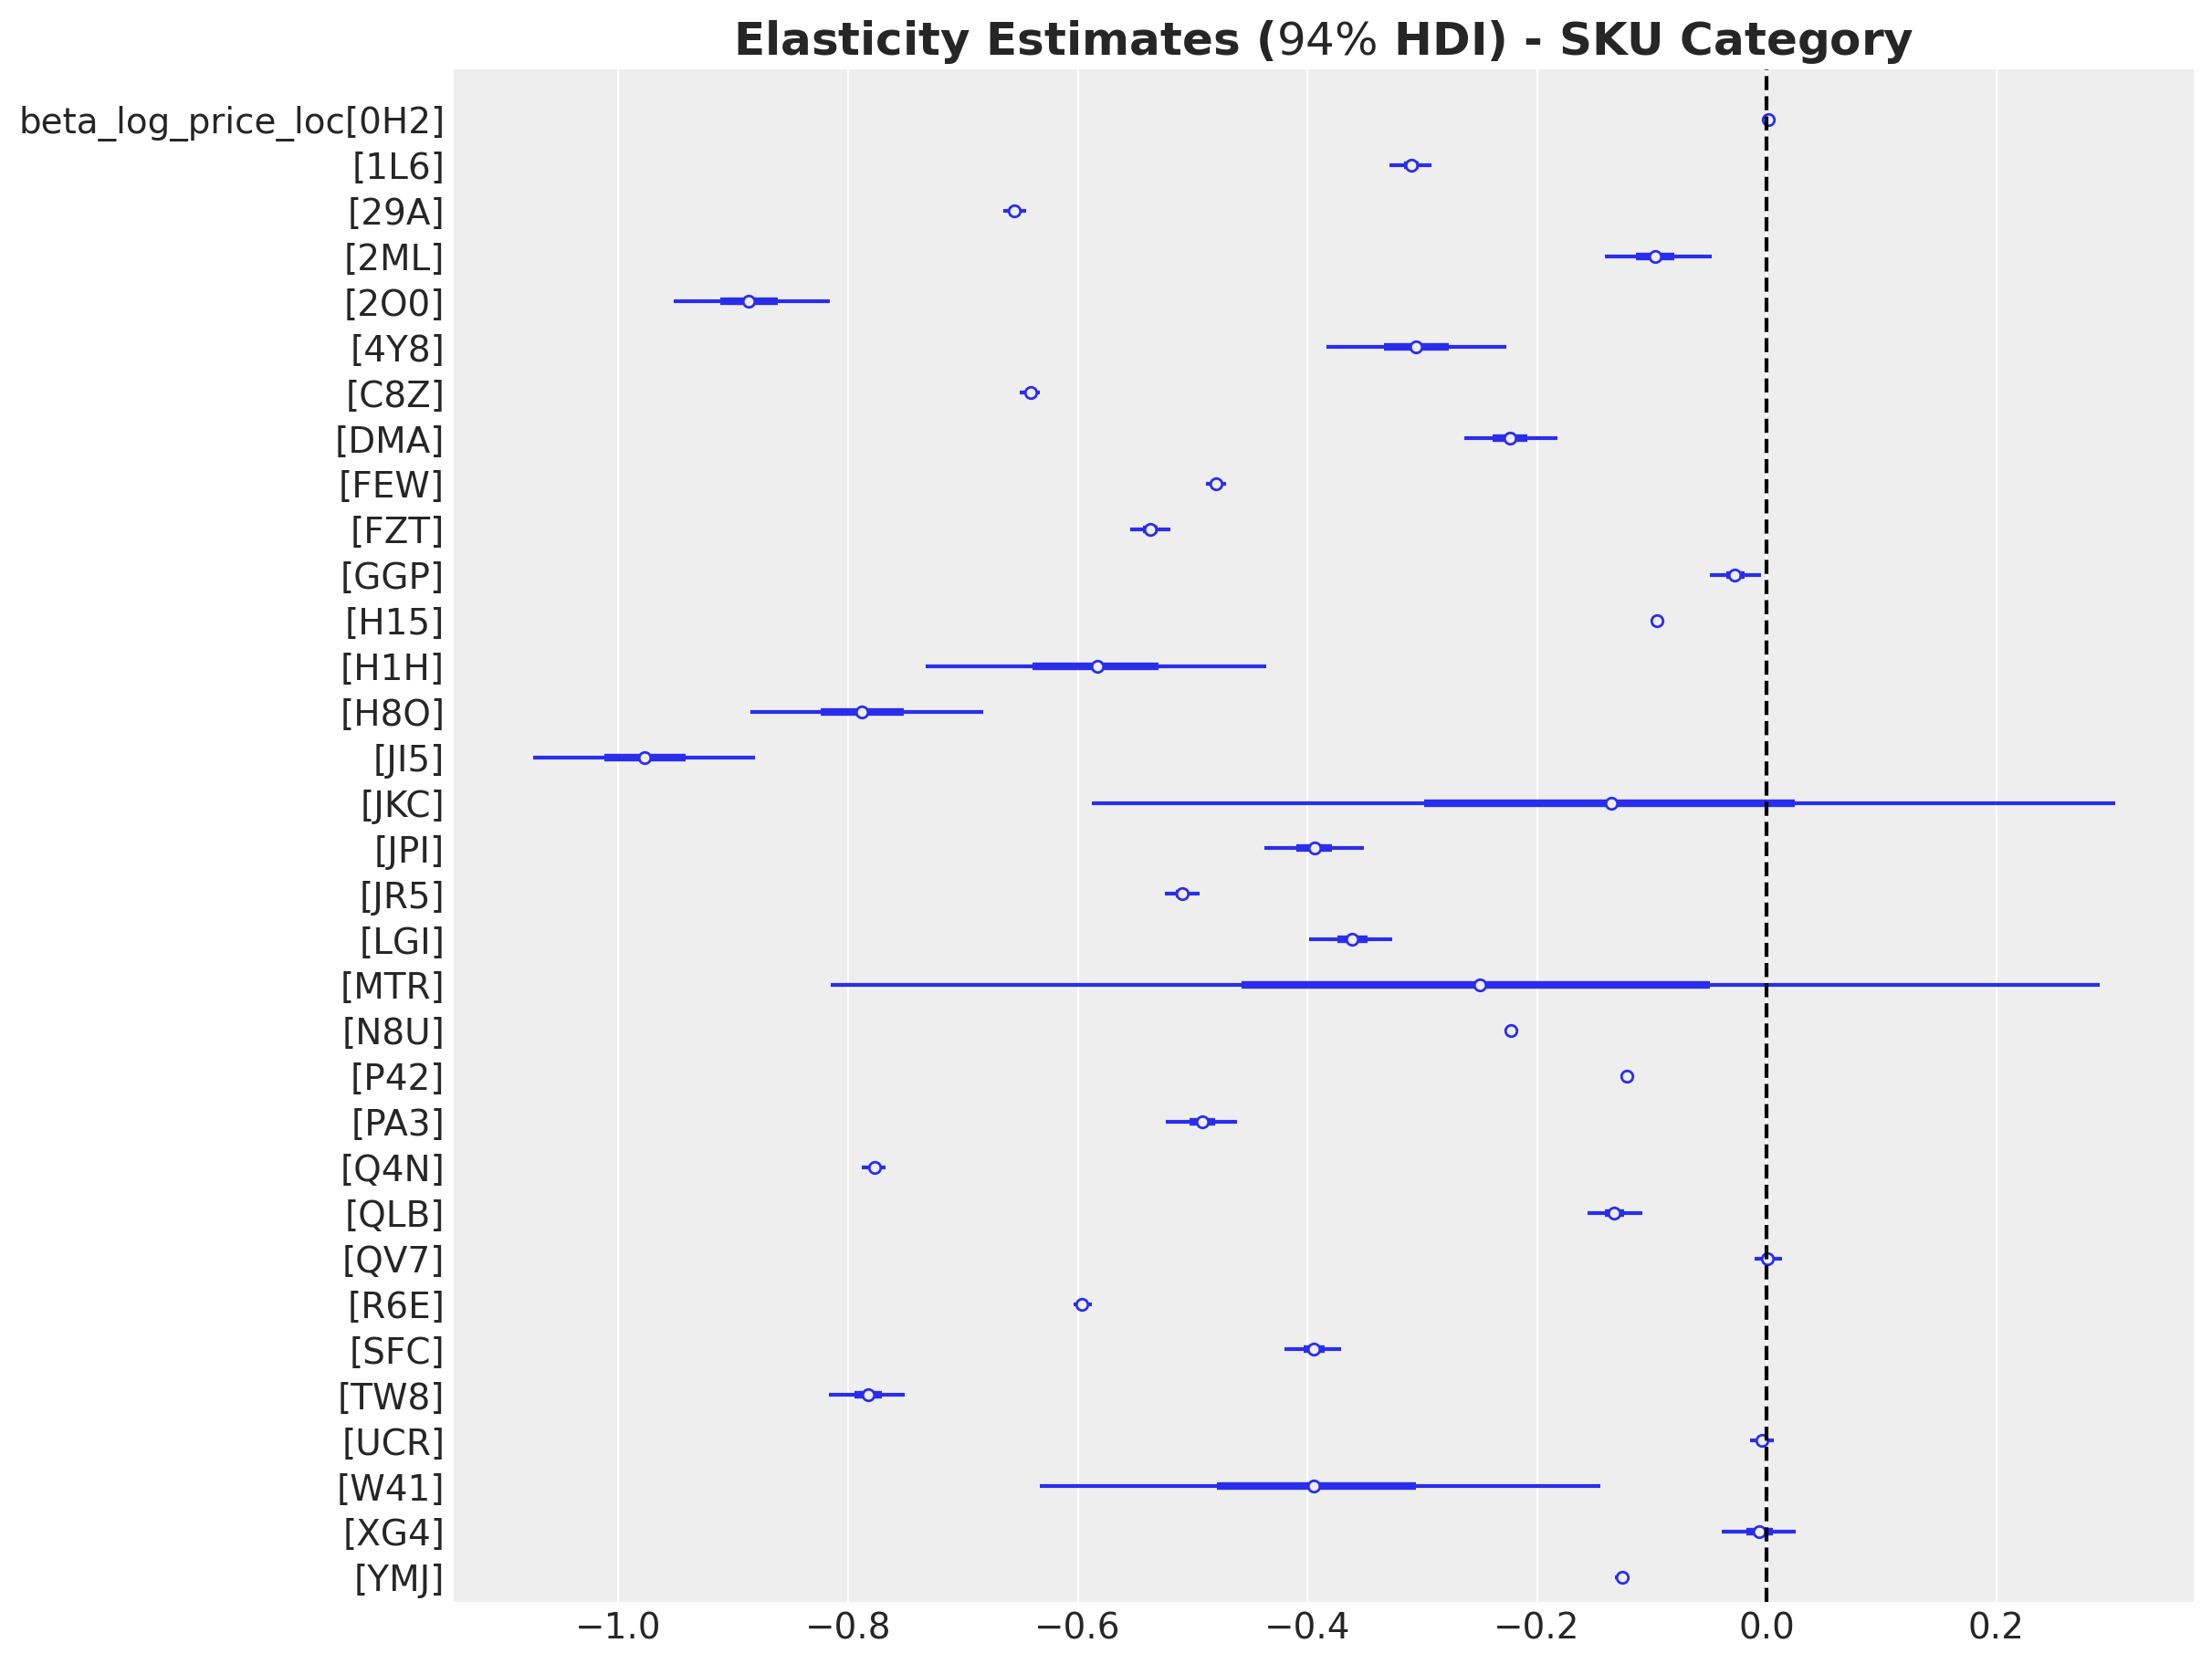

In [32]:
fig, ax = plt.subplots(figsize=(12, 9))
az.plot_forest(
    data=svi_idata,
    var_names=["beta_log_price_loc"],
    combined=True,
    ax=ax,
)
ax.axvline(x=0, color="black", linestyle="--")
ax.set_title(
    r"Elasticity Estimates ($94\%$ HDI) - SKU Category", fontsize=18, fontweight="bold"
);

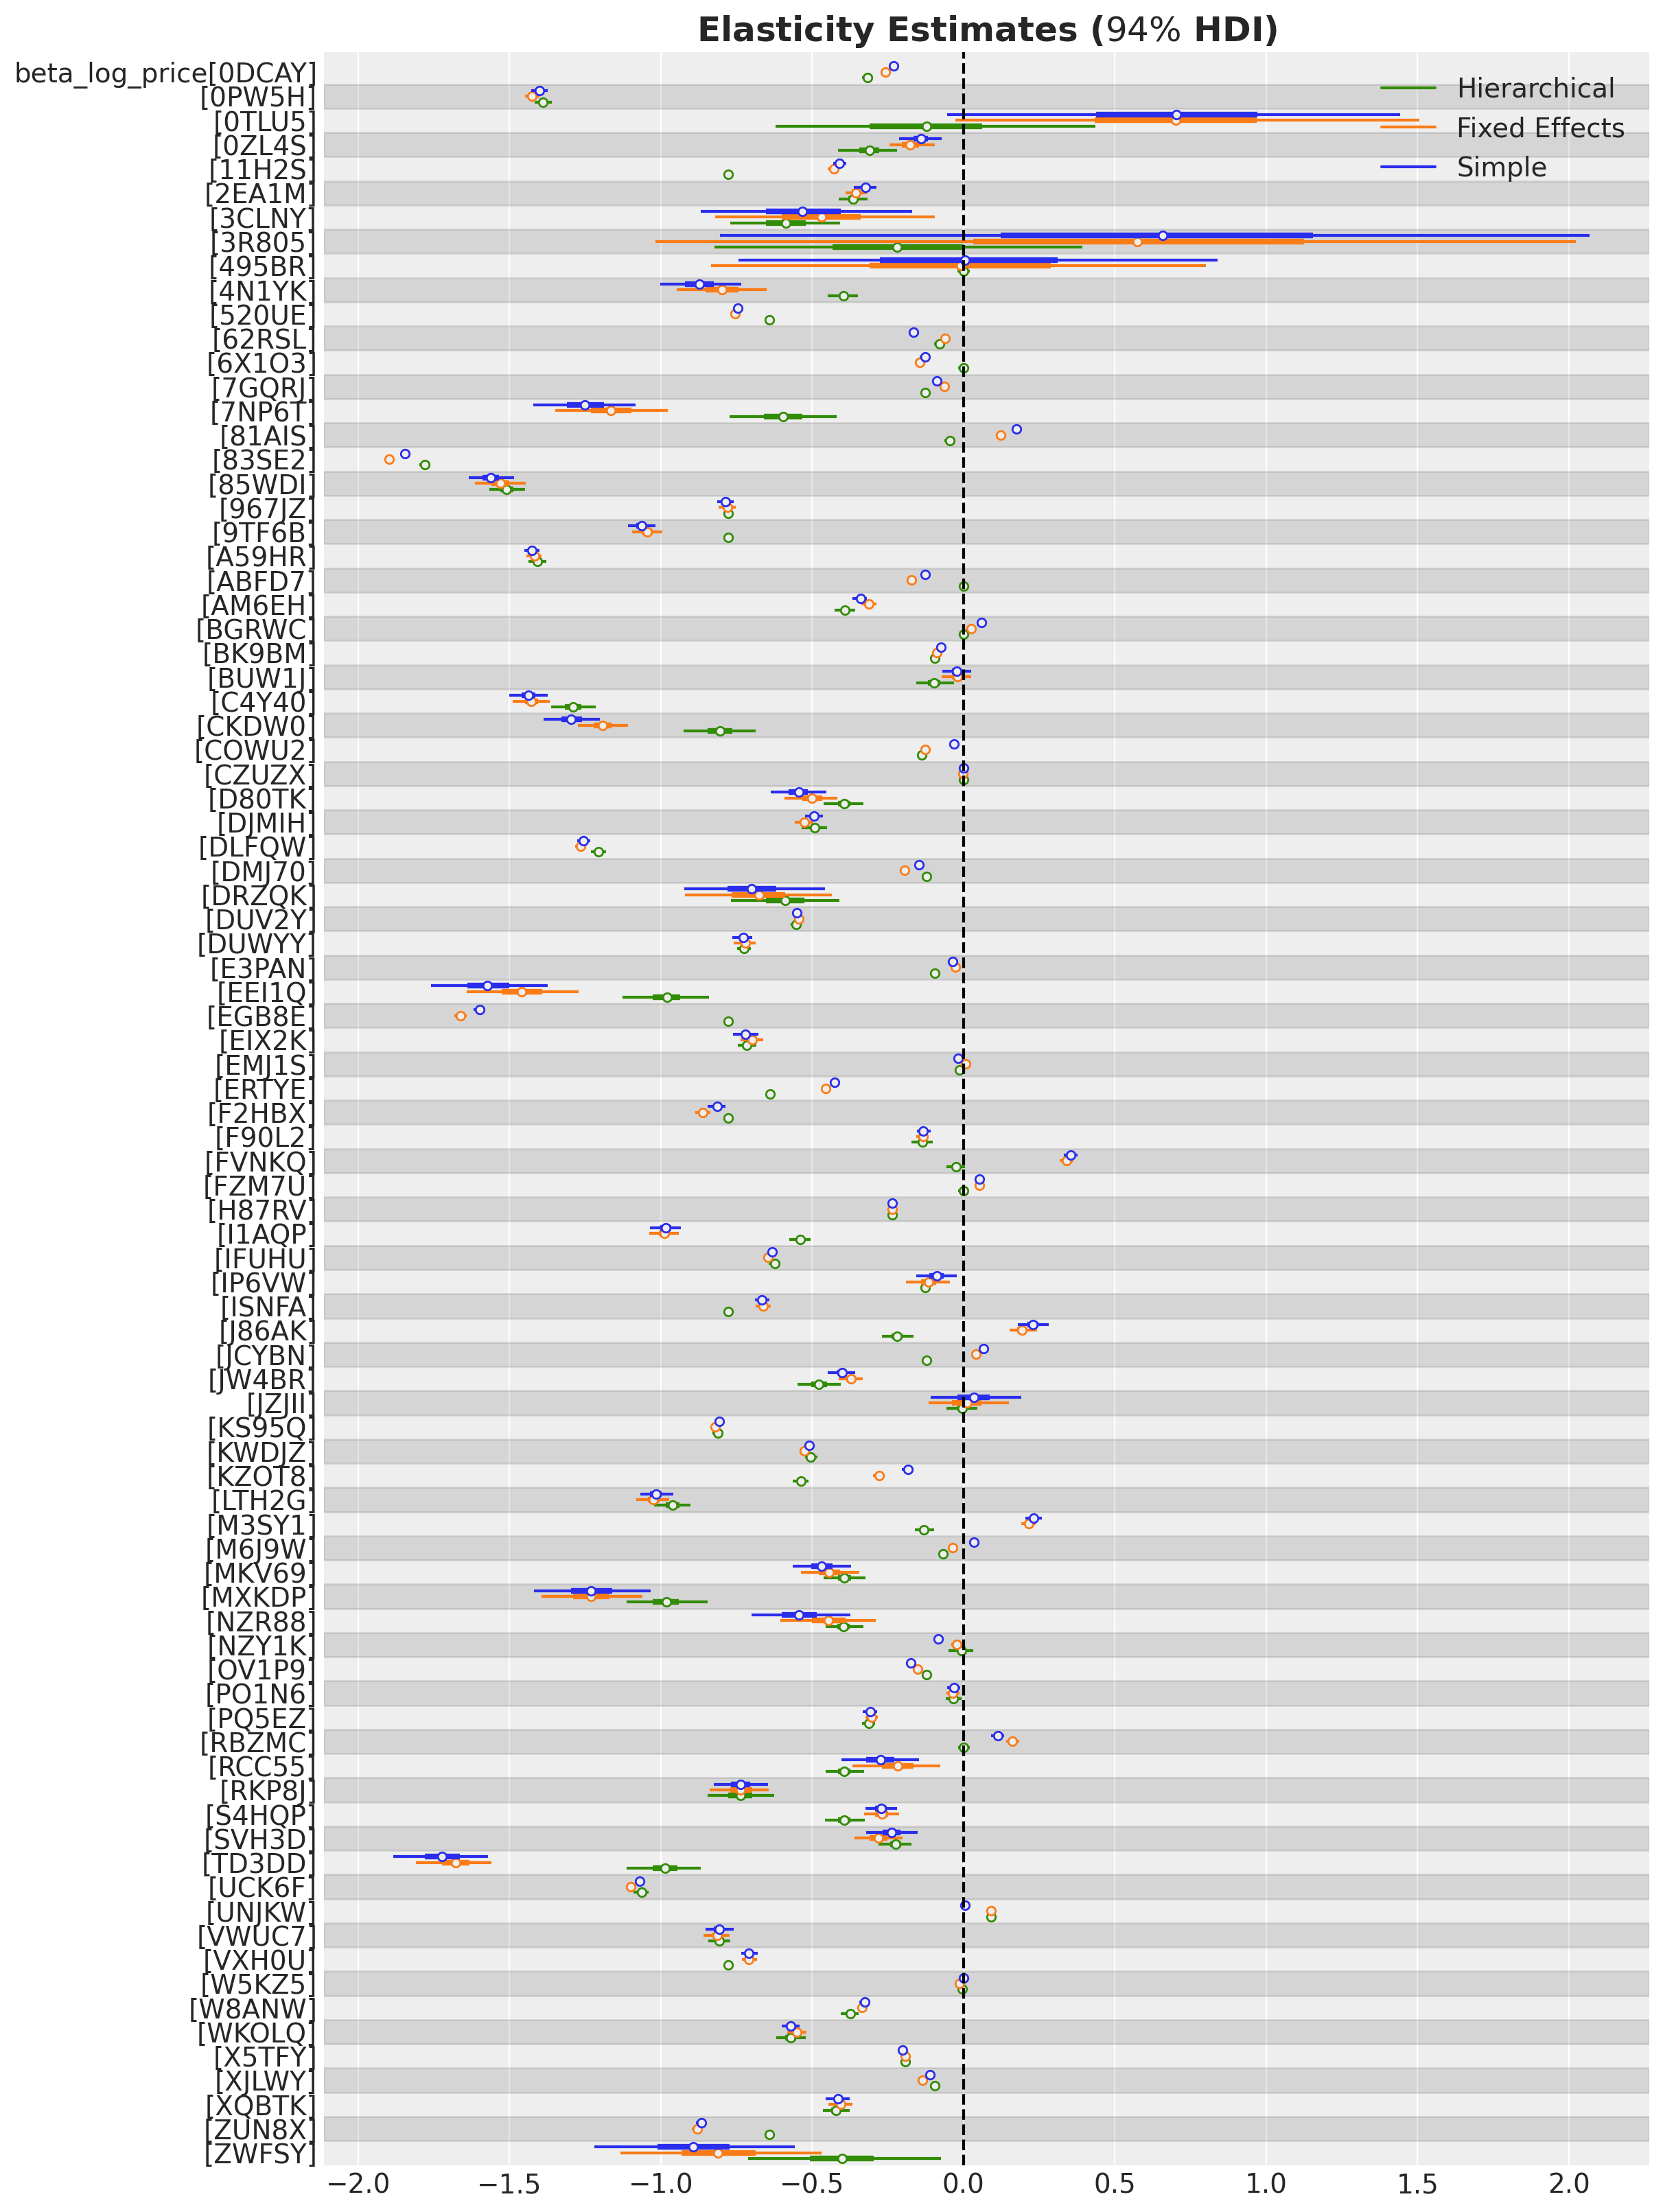

In [28]:
fig, ax = plt.subplots(figsize=(12, 16))
az.plot_forest(
    data=[simple_svi_idata, fixed_effects_svi_idata, svi_idata],
    model_names=["Simple", "Fixed Effects", "Hierarchical"],
    var_names=["beta_log_price"],
    combined=True,
    ax=ax,
)
ax.axvline(x=0, color="black", linestyle="--")
ax.set_title(
    r"Elasticity Estimates ($94\%$ HDI)",
    fontsize=18,
    fontweight="bold",
);

In [30]:
rng_key, rng_subkey = random.split(rng_key)
svi_posterior_predictive = Predictive(
    model=reparam_hierarchical_elasticity_model,
    params=svi_result.params,
    guide=guide,
    num_samples=5_000,
    return_sites=["obs"],
)(
    rng_subkey,
    log_price,
    sku_idx,
    date_idx,
    sku_category_idx,
    sku_category_mapping,
)

svi_idata.extend(
    az.from_numpyro(
        posterior_predictive=svi_posterior_predictive,
        coords={"obs": obs_idx},
        dims={"obs": ["obs_idx"]},
    )
)

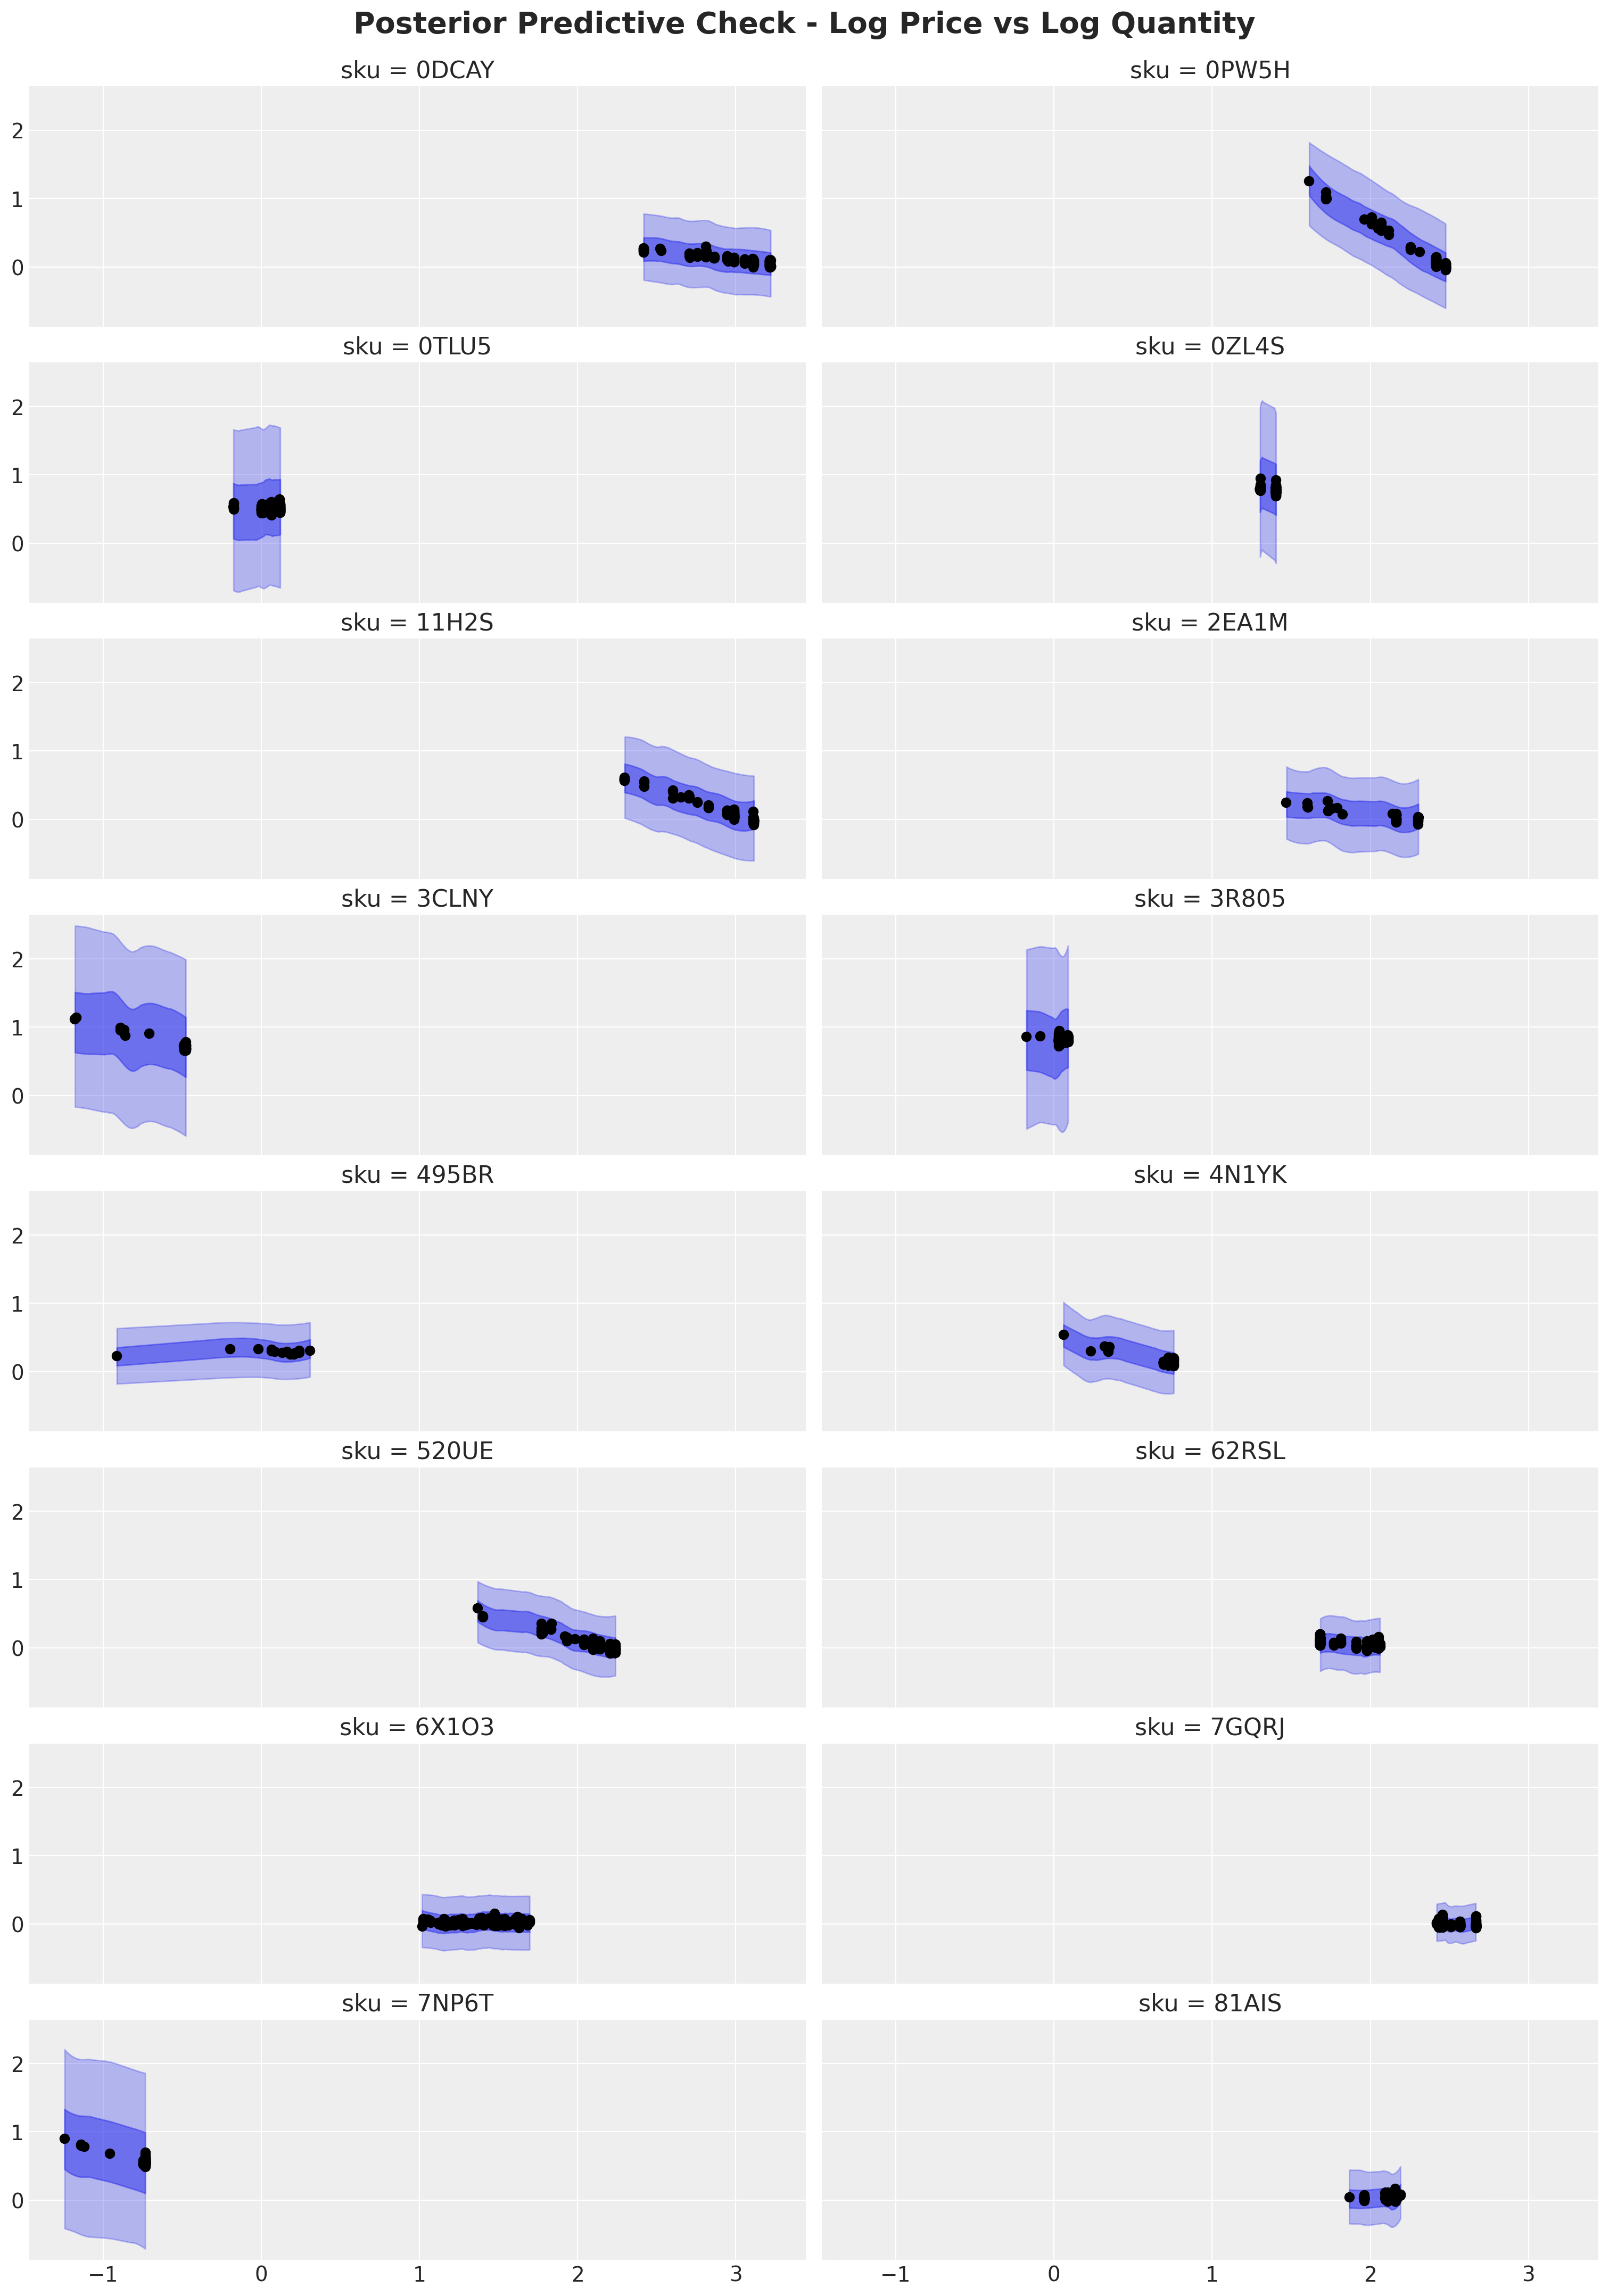

In [31]:
n_skus = 16

fig, axes = plt.subplots(
    nrows=n_skus // 2,
    ncols=2,
    figsize=(15, 21),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for _idx in range(n_skus):
    sku_idx_obs_posterior = svi_idata["posterior_predictive"]["obs"][
        :, :, (model_df["sku"] == sku[_idx])
    ]

    ax = axes[_idx]

    az.plot_hdi(
        model_df.filter(pl.col("sku") == sku[_idx])["log_price"],
        sku_idx_obs_posterior,
        hdi_prob=0.95,
        color="C0",
        fill_kwargs={"alpha": 0.3},
        ax=ax,
    )
    az.plot_hdi(
        model_df.filter(pl.col("sku") == sku[_idx])["log_price"],
        sku_idx_obs_posterior,
        hdi_prob=0.5,
        color="C0",
        fill_kwargs={"alpha": 0.5},
        ax=ax,
    )

    ax.scatter(
        model_df.filter(pl.col("sku") == sku[_idx])["log_price"],
        sku_idx_obs_posterior.mean(dim=("chain", "draw")),
        color="black",
    )

    ax.set(title=f"sku = {sku[_idx]}")

fig.suptitle(
    "Posterior Predictive Check - Log Price vs Log Quantity",
    fontsize=20,
    fontweight="bold",
    y=1.02,
);